![YouTube Logo](./images/20240322_1525_youtube.jpg)

**Step 1: Understanding the problem**


<a id="top"></a>

We are Noa Valentina marketing company, specialized in providing consultancy to content creators

We could predict with high accuracy which keywords are the more successful ones predicting total views

Data source is from

https://www.kaggle.com/datasets/asaniczka/2024-youtube-channels-1-million


**Step 2: Importing libraries and customized functions**

In [1]:
import ast  # Module for literal_eval
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
import pickle

import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler,MultiLabelBinarizer,OneHotEncoder,OrdinalEncoder,StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from tensorflow.keras import regularizers
from xgboost import XGBRegressor
#customized functions

import scripts.bootcampviztools as bc
import scripts.data_functions as dafu
import scripts.toolbox_ML as tb






**Step 3: Importing data** 

[Back to the top](#top)

As Github does not allow >100 Megabytes file, data is compressed in ZIP format in blocks of 50 Megabytes

If CSV file already exists it does nothing

In [2]:
try:
    import zipfile
    print("zipfile is already installed.")
except ImportError:
    print("zipfile not found. Installing...")
    %pip install zipfile

zipfile is already installed.


In [3]:
csv_relative_path ="./data/youtube_channels_1M_clean.csv"



Decompressing ZIP multipart archive in ./data/

In [4]:
if os.path.exists(csv_relative_path)==False:
    # Relative path or file name
    relative_path = 'data/'
    archive_name='youtube_channels_1M_clean.zip'
    zip_prefix = "youtube_channels_1M_clean.zip."
    # Get the current working directory
    cwd = os.getcwd()

    # Combine them to form a full path
    full_archive_path = os.path.join(cwd, relative_path).replace("\\","/")
    full_archive_path = os.path.join(full_archive_path, archive_name).replace("\\","/")
    full_zip_prefix = os.path.join(cwd, relative_path).replace("\\","/")
    full_zip_prefix = os.path.join(full_zip_prefix, zip_prefix).replace("\\","/")
    full_output_path = os.path.join(cwd, relative_path).replace("\\","/")



    # Output directory where the files will be extracted
    output_directory = './data/'

    # N number of parts
    import glob

    parts = glob.glob(full_zip_prefix + '*')
    for index,part in enumerate(parts):
        parts[index]=part.replace("\\","/")
    n = len(parts)
    # Concatenate
    with open(full_archive_path , "wb") as outfile:
        for i in range(1, n+1):
            filename = full_zip_prefix + str(i).zfill(3)
            with open(filename, "rb") as infile:
                outfile.write(infile.read())

    #Extract
    with zipfile.ZipFile(full_archive_path, "r") as zip_ref:
        zip_ref.extractall(full_output_path)

    print("Extraction complete!")
else:
    print("CSV already exists!")

CSV already exists!


<a id="top"></a>

In [5]:
# Reading CSV 
file_path = './data/youtube_channels_1M_clean.csv'
df = pd.read_csv(file_path)


Before cleaning data

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1095242 entries, 0 to 1095241
Data columns (total 16 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   channel_id                   1095242 non-null  object 
 1   channel_link                 1095242 non-null  object 
 2   channel_name                 1095182 non-null  object 
 3   subscriber_count             1095242 non-null  int64  
 4   banner_link                  766877 non-null   object 
 5   description                  819743 non-null   object 
 6   keywords                     547203 non-null   object 
 7   avatar                       1095242 non-null  object 
 8   country                      620059 non-null   object 
 9   total_views                  1094490 non-null  float64
 10  total_videos                 1094985 non-null  float64
 11  join_date                    1095220 non-null  object 
 12  mean_views_last_30_videos    1059085 non-n

In [7]:
dafu.data_report(df)

COL_N         channel_id channel_link channel_name subscriber_count  \
DATA_TYPE         object       object       object            int64   
MISSINGS (%)         0.0          0.0         0.01              0.0   
UNIQUE_VALUES    1095242      1095242      1074699             4839   
CARDIN (%)         100.0        100.0        98.12             0.44   

COL_N         banner_link description keywords   avatar country total_views  \
DATA_TYPE          object      object   object   object  object     float64   
MISSINGS (%)        29.98       25.15    50.04      0.0   43.39        0.07   
UNIQUE_VALUES      766877      813114   540989  1084087     229      546421   
CARDIN (%)          70.02       74.24    49.39    98.98    0.02       49.89   

COL_N         total_videos join_date mean_views_last_30_videos  \
DATA_TYPE          float64    object                   float64   
MISSINGS (%)          0.02       0.0                       3.3   
UNIQUE_VALUES        11540      6791                    390469   
CARDIN (%)            1.05      0.62                     35.65   

COL_N         median_views_last_30_videos std_views_last_30_videos  \
DATA_TYPE                         float64                  float64   
MISSINGS (%)                          3.3                      3.3   
UNIQUE_VALUES                       75888                   951657   
CARDIN (%)                           6.93                    86.89   

COL_N         videos_per_week  
DATA_TYPE             float64  
MISSINGS (%)              3.3  
UNIQUE_VALUES              31  
CARDIN (%)                0.0

[Back to the top](#top)

Filtering data to get a clean DataFrame 

filtering by Countries and that are null **ADD MORE DETAIL OR LINE BY LINE**

In [8]:

df_filtered_1 = df[df[['country']].notna().all(axis=1)].copy()

df_filtered_2 =df_filtered_1[df_filtered_1[['keywords']].notna().all(axis=1)].copy()
df_filtered_3 =df_filtered_2[df_filtered_2['subscriber_count']>0].copy()
df_filtered_4 =df_filtered_3[df_filtered_3[['total_views']].notna().all(axis=1)].copy()
df_filtered_5=df_filtered_4[df_filtered_4[['description']].notna().all(axis=1)].copy()
df_filtered_5=df_filtered_5[df_filtered_5['videos_per_week']>0].copy()
df_filtered_backup=df_filtered_5.copy()
df=df_filtered_5

After cleaning data

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183514 entries, 3 to 1095226
Data columns (total 16 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   channel_id                   183514 non-null  object 
 1   channel_link                 183514 non-null  object 
 2   channel_name                 183504 non-null  object 
 3   subscriber_count             183514 non-null  int64  
 4   banner_link                  173351 non-null  object 
 5   description                  183514 non-null  object 
 6   keywords                     183514 non-null  object 
 7   avatar                       183514 non-null  object 
 8   country                      183514 non-null  object 
 9   total_views                  183514 non-null  float64
 10  total_videos                 183514 non-null  float64
 11  join_date                    183513 non-null  object 
 12  mean_views_last_30_videos    183514 non-null  float64
 13  med

In [10]:
dafu.data_report(df)

COL_N         channel_id channel_link channel_name subscriber_count  \
DATA_TYPE         object       object       object            int64   
MISSINGS (%)         0.0          0.0         0.01              0.0   
UNIQUE_VALUES     183514       183514       183055             4721   
CARDIN (%)         100.0        100.0        99.75             2.57   

COL_N         banner_link description keywords  avatar country total_views  \
DATA_TYPE          object      object   object  object  object     float64   
MISSINGS (%)         5.54         0.0      0.0     0.0     0.0         0.0   
UNIQUE_VALUES      173351      182926   182849  183495     179      172282   
CARDIN (%)          94.46       99.68    99.64   99.99     0.1       93.88   

COL_N         total_videos join_date mean_views_last_30_videos  \
DATA_TYPE          float64    object                   float64   
MISSINGS (%)           0.0       0.0                       0.0   
UNIQUE_VALUES         8819      6738                    113126   
CARDIN (%)            4.81      3.67                     61.64   

COL_N         median_views_last_30_videos std_views_last_30_videos  \
DATA_TYPE                         float64                  float64   
MISSINGS (%)                          0.0                      0.0   
UNIQUE_VALUES                       38593                   181651   
CARDIN (%)                          21.03                    98.98   

COL_N         videos_per_week  
DATA_TYPE             float64  
MISSINGS (%)              0.0  
UNIQUE_VALUES              30  
CARDIN (%)               0.02

[Back to the top](#top)

**Step 4: Dataset explanation**

https://www.kaggle.com/datasets/asaniczka/2024-youtube-channels-1-million

This dataset contains information on 1 million (plus a bit more) YouTube channels. Channels were picked randomly to extract data.

It includes insights into subscriber counts, total views, total videos, engagement statistics, and more.

I've added some aggregated data about videos of each channel as well.

**Dataset:**  youtube_channels_1M_clean.csv  

**Description:** This dataset contains information on 0 million (plus a bit more) YouTube channels. Channels were picked randomly to extract data.

It includes insights into subscriber counts, total views, total videos, engagement statistics, and more.

It has been added some aggregated data about videos of each channel as well.

**Period:**  From 02/05/2005 to 09/03/2024

<h0>df</h0>
<table>
<tr><th>Column/Variable</th><th>Description</th><th>Variable type</th><th>Importance</th><th>Note</th></tr>
<tr><td>channel_id</td><td>Unique ID assigned to each YouTube channel. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>channel_link</td><td>Link to the YouTube channel. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>channel_name</td><td>Name of the YouTube channel. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>subscriber_count</td><td>Number of subscribers the channel has. (type:int)</td><td>int</td><td>1</td><td></td></tr>
<tr><td>banner_link</td><td>Link to the channel's banner image. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>description</td><td>Brief description of the channel. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>keywords</td><td>Keywords associated with the channel's content. Do .split(", ") to convert to a list (type:str)</td><td>object</td><td>1</td><td></td></tr>
<tr><td>avatar</td><td>Link to the channel's avatar image. (type:str)</td><td>object</td><td>0</td><td></td></tr>
<tr><td>country</td><td>Country of the YouTuber</td><td>object</td><td>1</td><td></td></tr>
<tr><td>total_views</td><td>Total number of views the channel has received. (type:float)</td><td>float</td><td>1</td><td>Target of the model</td></tr>
<tr><td>total_videos</td><td>Total number of videos of the channel. (type:float)</td><td>float</td><td>1</td><td></td></tr>
<tr><td>join_date</td><td>Date when YouTube Channel was created</td><td>object</td><td>1</td><td></td></tr>
<tr><td>mean_views_last_30_videos</td><td>Mean views of last 30 videos</td><td>float</td><td>1</td><td></td></tr>
<tr><td>median_views_last_30_videos</td><td>Median views of last 30 videos</td><td>object</td><td>1</td><td></td></tr>
<tr><td>std_views_last_30_videos</td><td>Standard views of last 30 videos</td><td>object</td><td>1</td><td></td></tr>
<tr><td>videos_per_week</td><td>Number of videos uploaded per week</td><td>object</td><td>1</td><td></td></tr>
</table>

[Back to the top](#top)

**Step 5: Visualizing data and EDA**

Defining Target variable

In [11]:
target="total_views"


Presenting 10 records

In [12]:
df.head(10)


channel_id              channel_link  \
3   UCAQOeJwsgBMC74-OjjcQcJA      /@JerryAndJulieMusic   
9   UCWTnzxJ58oAfydJ_0Fgm6fg   /@yourshealthbeauty7219   
15  UCoX36PeEA0NYJ5tCl4YDPYw             /@TheAntwiwaa   
16  UCl1PIKAnK7Q53KVBudhg54Q  /@DrMichaelsDentalClinic   
23  UCc-N24Y5OA0gqbjBwe1ttfA            /@WeirdHistory   
24  UC9qgVkKRZUXcgHdf35Z-8dw    /@MyLittlePonyOfficial   
26  UCQXKj_Nl1FRBRHRmama6_rw     /@nabahatskitchen3566   
43  UCUz1YxdzDB5s_vmaq5L1mXQ            /@jessiraeyoga   
46  UCmRY4NSGK52lP_Lz11CjdYw                /@VyQwaint   
58  UC5kFNaPfZ-ilbaJA5d-djnw  /@JubilantJulietsKitchen   

                   channel_name  subscriber_count  \
3           Jerry & Julie Music              1090   
9         Yours Health & Beauty              1380   
15                 The Antwiwaa             20900   
16  Dr. Michael's Dental Clinic             11200   
23                Weird History           4420000   
24      My Little Pony Official           5200000   
26            Nabahat's Kitchen              1120   
43               Jessi Rae Yoga             10000   
46                    Vy Qwaint          11700000   
58    Jubilant Juliet's Kitchen              1450   

                                          banner_link  \
3   https://yt3.googleusercontent.com/dI6Oq0iOhx-c...   
9   https://yt3.googleusercontent.com/0C9r0JCPlFP3...   
15  https://yt3.googleusercontent.com/0Pv02_bXlrxX...   
16  https://yt3.googleusercontent.com/GMQtvVYhluJU...   
23  https://yt3.googleusercontent.com/ch1dKorOrP9C...   
24  https://yt3.googleusercontent.com/1suA06oSD-Cz...   
26  https://yt3.googleusercontent.com/wZGbUiqF5KS9...   
43  https://yt3.googleusercontent.com/XR9J9TH5-hGs...   
46  https://yt3.googleusercontent.com/fwOzkmFf8Wwe...   
58  https://yt3.googleusercontent.com/cqlwYaxELjIO...   

                                          description  \
3   Welcome to Jerry & Julie Music.  We hope you w...   
9   Hey beautiful and special people's I share ver...   
15  Dairy of a young woman figuring out life, her ...   
16  Dr. Michael's Dental Clinic is your one-stop s...   
23  Welcome to the chronicles of history that was ...   
24  Welcome everypony 🦄  to the official home of M...   
26  Hello friends ....\n\nWelcome to the Nabahat's...   
43  Jessi Rae is an internationally known yoga ins...   
46  Hi, my name is Vy! My husband Chad Wild Clay a...   
58  \n\nHello, my name is Juliet\nWelcome to my ch...   

                                             keywords  \
3   jerryandjuliemusic, jerryspianobar, juliesguit...   
9                 Health, Beauty, Tips, Food, Fashion   
15  financial literacy, personal growth, personal ...   
16  dental, dentist, dental clinic, orthodontist, ...   
23  weird history, historical facts, history, hist...   
24  my little pony, pony, little pony, my little p...   
26  recipes for beginners, cupcakes ideas, eggless...   
43  jessi rae yoga, yoga, wild roots yoga, jessi r...   
46  fashion, how-to, lifestyle, beauty, hairstyle,...   
58  Healthy meal recipes, How to cook, Quick meal ...   

                                               avatar               country  \
3   https://yt3.googleusercontent.com/c41pe3_aA75h...         United States   
9   https://yt3.googleusercontent.com/ytc/AIdro_mI...              Pakistan   
15  https://yt3.googleusercontent.com/GE8vh-EJlPiT...        United Kingdom   
16  https://yt3.googleusercontent.com/ytc/AIdro_kv...  United Arab Emirates   
23  https://yt3.googleusercontent.com/UIPjlpb2xPE6...         United States   
24  https://yt3.googleusercontent.com/s4raSN25tWZb...         United States   
26  https://yt3.googleusercontent.com/hEvMvh8OWEj_...        United Kingdom   
43  https://yt3.googleusercontent.com/aT7FYA5nOzrg...         United States   
46  https://yt3.googleusercontent.com/8cahxhV_ZXGk...         United States   
58  https://yt3.googleusercontent.com/KwXjUpKQR9EQ...        United Kingdom   

     total_views  total_videos   join_dat

In [13]:
df.describe()


subscriber_count   total_views  total_videos  \
count      1.835140e+05  1.835140e+05  1.835140e+05   
mean       2.300656e+05  8.730981e+07  1.134137e+03   
std        1.721406e+06  1.109565e+09  7.253132e+03   
min        1.000000e+00  1.000000e+00  1.000000e+00   
25%        1.020000e+03  1.418332e+05  1.410000e+02   
50%        5.130000e+03  8.696430e+05  3.380000e+02   
75%        4.560000e+04  8.665082e+06  7.860000e+02   
max        2.440000e+08  1.788442e+11  1.248360e+06   

       mean_views_last_30_videos  median_views_last_30_videos  \
count               1.835140e+05                 1.835140e+05   
mean                4.479401e+04                 2.456732e+04   
std                 7.319309e+05                 5.512873e+05   
min                 0.000000e+00                 0.000000e+00   
25%                 1.722000e+02                 7.700000e+01   
50%                 8.914667e+02                 3.430000e+02   
75%                 6.174533e+03                 2.502000e+03   
max                 1.971791e+08                 1.783875e+08   

       std_views_last_30_videos  videos_per_week  
count              1.835140e+05    183514.000000  
mean               6.278170e+04         2.072691  
std                9.266876e+05         2.222977  
min                0.000000e+00         0.250000  
25%                1.967494e+02         0.500000  
50%                1.113299e+03         1.000000  
75%                8.560953e+03         2.750000  
max                1.613799e+08         7.500000

[Back to the top](#top)

Visualizing hist of targe

In [14]:
df[target].hist()

<Axes: >

Finding out outliers

In [15]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df[target].quantile(0.25)
Q3 = df[target].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
if lower_bound<0:
    lower_bound==1

print(f'Values below {lower_bound} and above {upper_bound} could be outliers.')

Values below -12643039.125 and above 21449953.875 could be outliers.


Visualizing data in a graph

In [16]:
df_no_outliers = df[(df[target] >= lower_bound) & (df[target] <= upper_bound)]


Plot

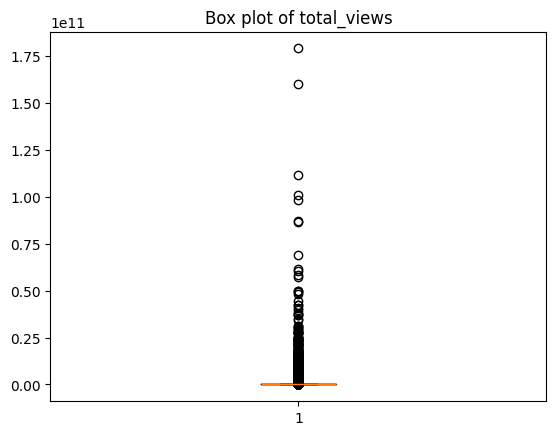

In [17]:
import matplotlib.pyplot as plt

plt.boxplot(df[target])
plt.title(f'Box plot of {target}')
plt.show()


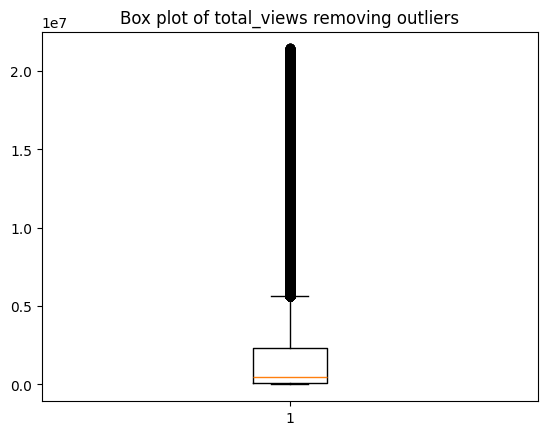

In [18]:
import matplotlib.pyplot as plt

plt.boxplot(df_no_outliers[target])
plt.title(f'Box plot of {target} removing outliers')
plt.show()

Histogram

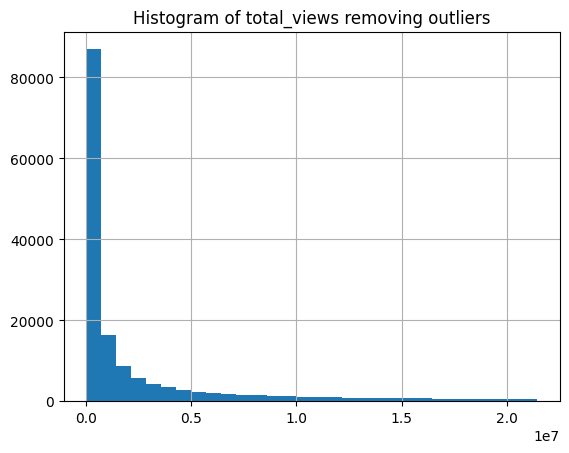

In [19]:
df_no_outliers[target].hist(bins=30)
plt.title(f'Histogram of {target} removing outliers')
plt.show()

[Back to the top](#top)

**Numeric Types in Python**

*int64*: Integer type that represents whole numbers (both positive and negative).

*float64*: Floating-point number that represents real numbers with a decimal point.

*int32*: A smaller integer type that occupies less memory and has a smaller range of integer representation compared to *int64*.

*float32*: A single-precision floating-point number that uses less memory than *float64*, at the cost of precision.

*int16* / *int8*: Even smaller integer types for memory efficiency when you know the range of your dataset is limited.

*uint8* / *uint16* / *uint32* / *uint64*: Unsigned integer types (only positive integers and zero) that can be useful for data that does not include negative numbers, such as image data.

*float16*: Half-precision floating-point; it's also known as "half" and is primarily used in GPU computing where high precision is not necessary.

*complex64* / *complex128*: Used to represent complex numbers, which have both a real and an imaginary part. The numbers before the name (64, 128) indicate the precision.

In [20]:
numeric_types=['int64','float64','int32','float32','int16','int8','uint8','uint16','uint32','uint64','float16','complex64','complex128']

Visualizing data in a graph

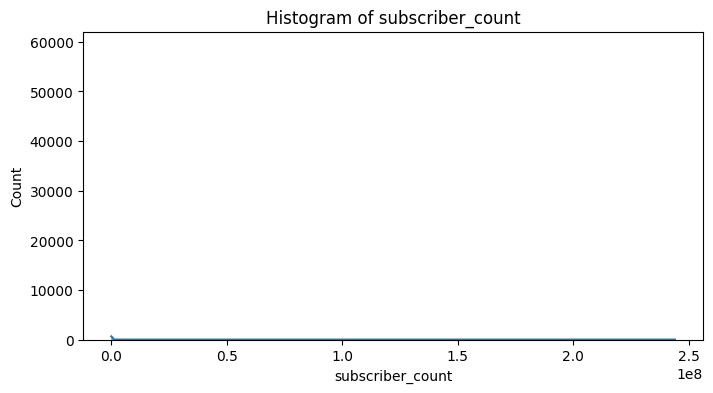

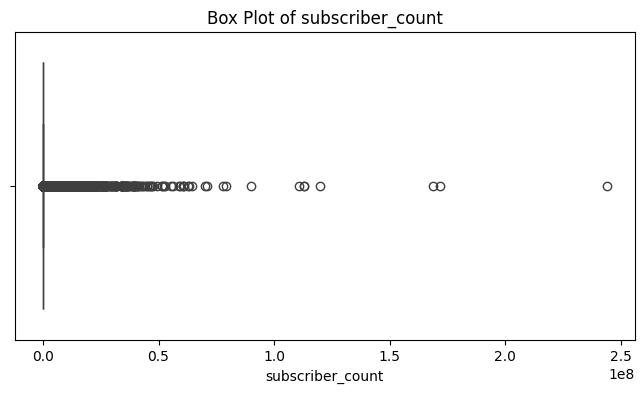

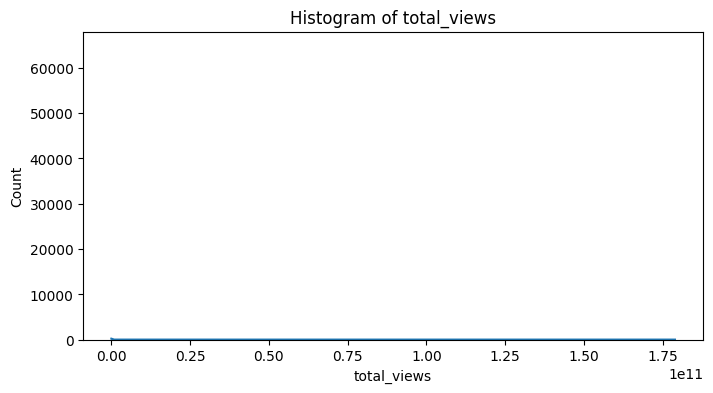

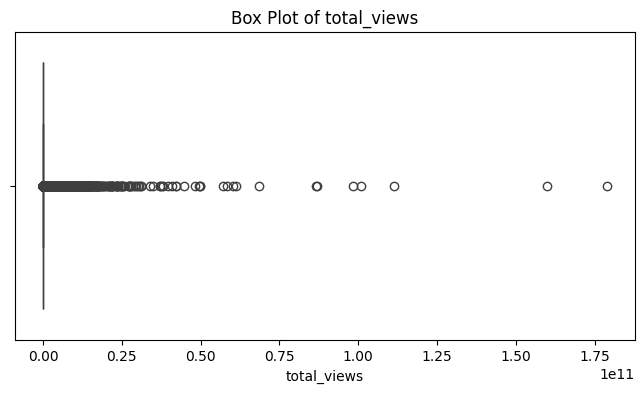

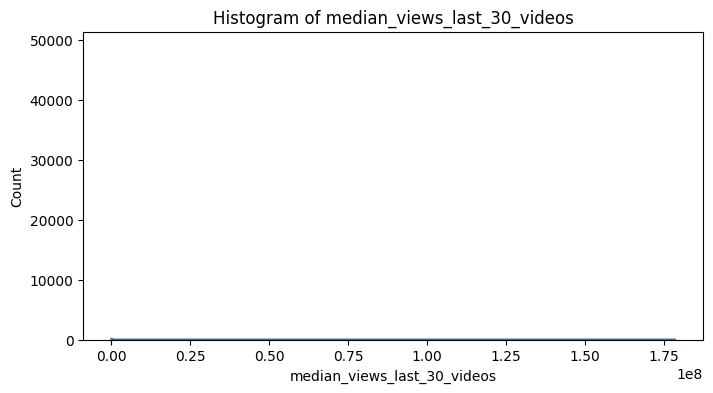

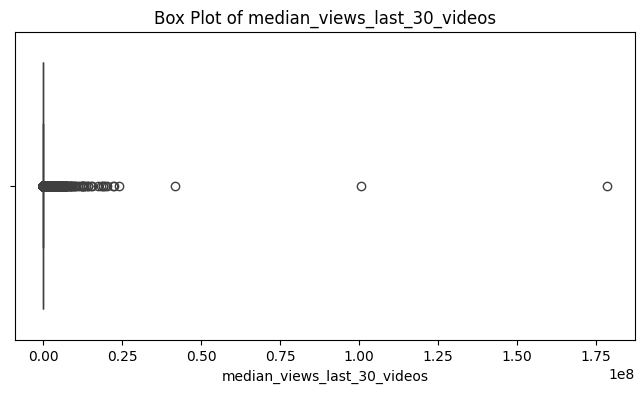

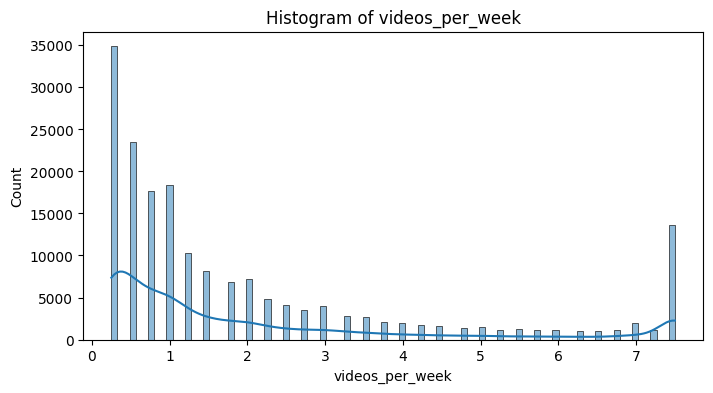

<module 'matplotlib.pyplot' from 'c:\\Users\\Jorge\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [22]:
dafu.eda1_num(df,target,df.select_dtypes(include=numeric_types).columns)

[Back to the top](#top)

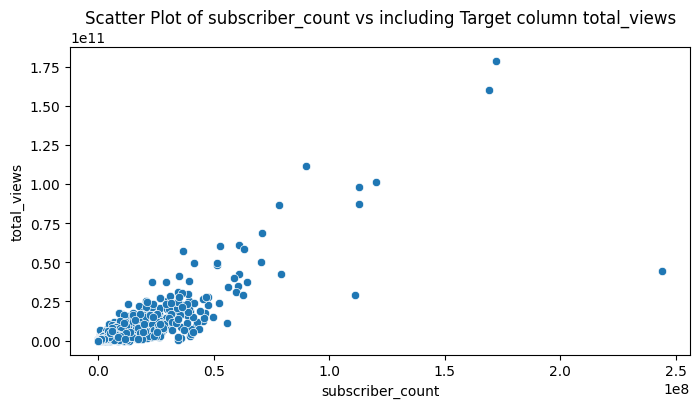

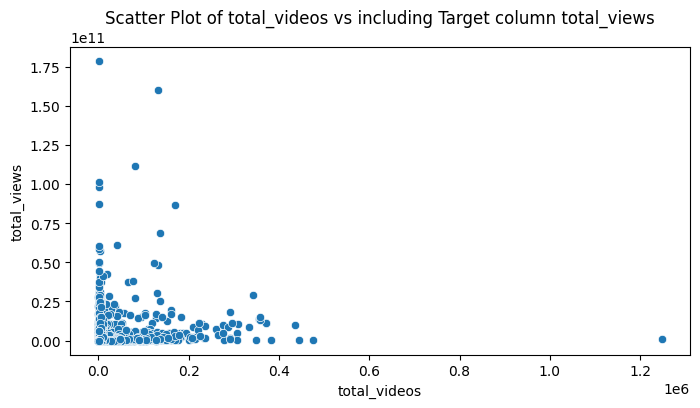

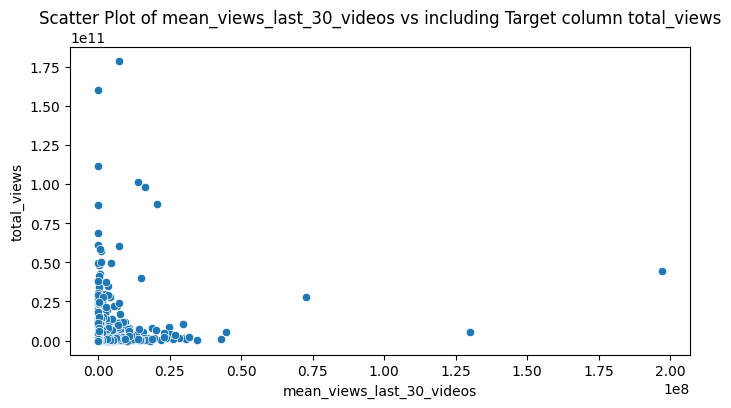

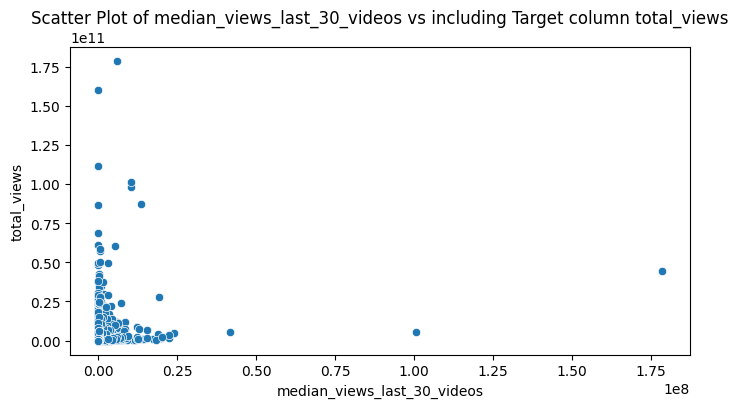

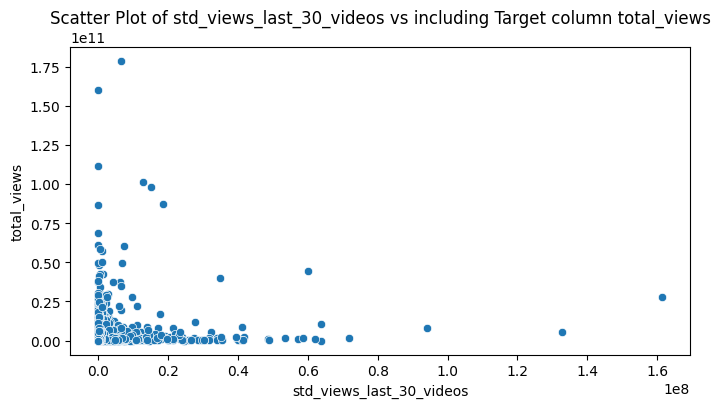

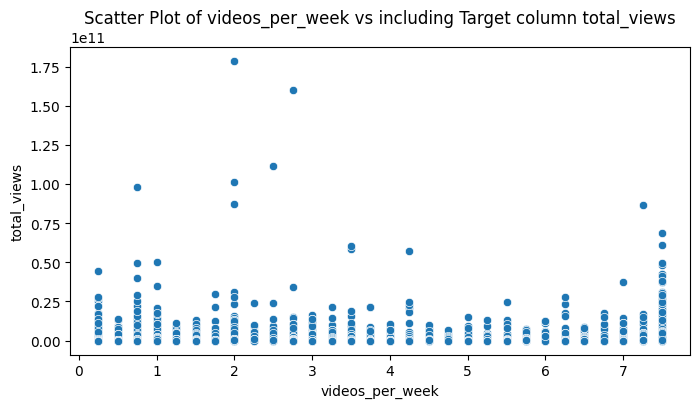

<module 'matplotlib.pyplot' from 'c:\\Users\\Jorge\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [23]:

dafu.eda2_num(df,target,df.select_dtypes(include=numeric_types).columns)

[Back to the top](#top)

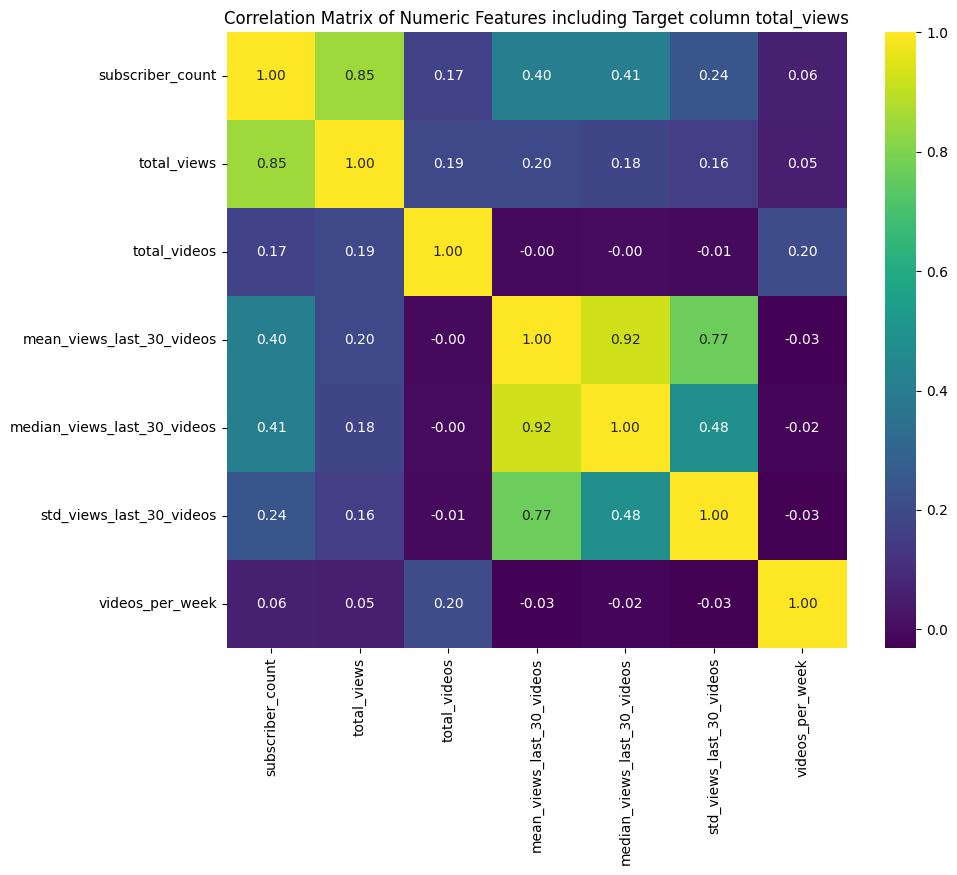

<module 'matplotlib.pyplot' from 'c:\\Users\\Jorge\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [24]:

dafu.eda3_num(df,target,df.select_dtypes(include=numeric_types).columns)

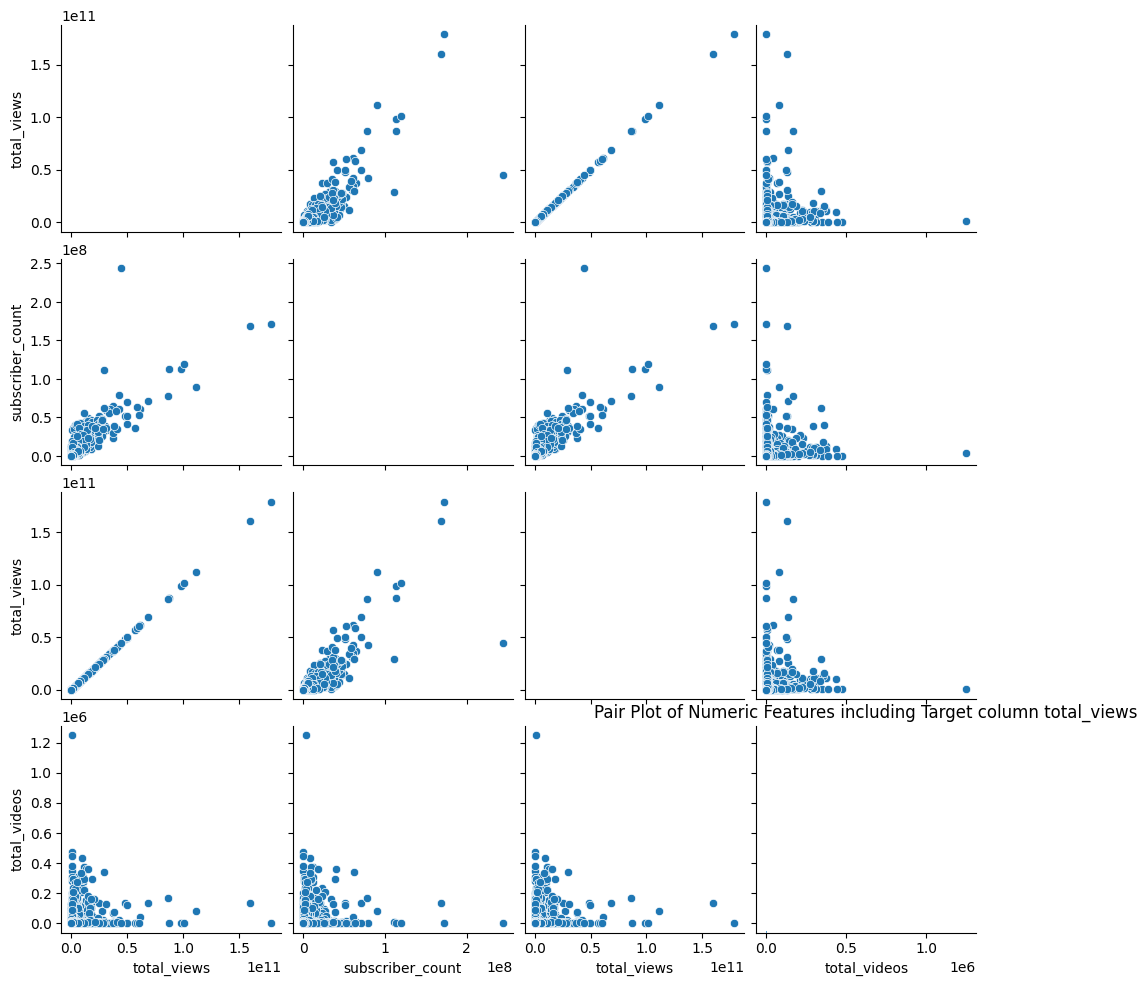

<module 'matplotlib.pyplot' from 'c:\\Users\\Jorge\\AppData\\Local\\Programs\\Python\\Python310\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [25]:

dafu.eda4_num(df,target,df.select_dtypes(include=numeric_types).columns)

[Back to the top](#top)

**Step 6: Data transformation**

Reading keywords (only the ones using English alphabet) from DataFrame prepared in advance, go to last step of this notebook to see how  I get this DataFrame

Filtering rows by existing keywords in keywords dataframe

df_no_outliers is now df

In [22]:
df=df_no_outliers

In [23]:
file_path = './data/youtube_channels_1M_clean_keywords.csv'
df_keywords=pd.read_csv(file_path)
df_keywords=df_keywords.sort_values(by="Count",ascending=False)
df_keywords=df_keywords.head(1000)
# Preprocess the keywords in df_data: lowercase and replace spaces with underscores
df['keywords'] = df['keywords'].str.lower().str.replace(' ', '_')

# Convert the keywords in df_data to a list of keywords for each row
df['keyword_list'] = df['keywords'].str.split(',')

# Check if any keyword in each row's list is in the df_keywords
df['keyword_match'] = df['keyword_list'].apply(
    lambda keywords: any(keyword in df_keywords['Keyword'].values for keyword in keywords)
)

# Filter df_data based on whether there's a keyword match
filtered_df = df[df['keyword_match']]


# Drop the temporary columns if they are no longer needed
#filtered_df = filtered_df.drop(['keyword_list', 'keyword_match'], axis=1)
filtered_df = filtered_df.drop(['keyword_match'], axis=1)
filtered_df
df=filtered_df

C:\Users\Jorge\AppData\Local\Temp\ipykernel_14860\1792521758.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keywords'] = df['keywords'].str.lower().str.replace(' ', '_')
C:\Users\Jorge\AppData\Local\Temp\ipykernel_14860\1792521758.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword_list'] = df['keywords'].str.split(',')
C:\Users\Jorge\AppData\Local\Temp\ipykernel_14860\1792521758.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

Filtering by total_videos greater than 0 and adding a date column with datetime type

Also adding year,month,day and dayofweek as numeric

In [24]:
#Filter total_videos greater than 0
df= df[df['total_videos']>=0]
#Add a column datetime type and extract numeric year,month, date and date of the week
df['join_date_datetime']=pd.to_datetime(df['join_date'])
df['year'] = df['join_date_datetime'].dt.year
df['month'] = df['join_date_datetime'].dt.month
df['day'] = df['join_date_datetime'].dt.day
df['dayofweek'] = df['join_date_datetime'].dt.dayofweek
#filtering columns for later ML/DL


Preparing list of columns for dropping on train_split

In [25]:
features_cat= ['keywords']
drop_columns=['channel_id', 
              'channel_link', 
              'channel_name', 
              'banner_link', 
              'description', 
              'keywords', 
              'avatar', 
              'country',
              'keyword_list',
              'country_formatted',
              'join_date',
              'join_date_datetime']

OneHotEncoder with country and keywords due to issues with working on lists

Adding a column with country name formatted 

In [26]:
#OneHotEncoder due to issues with working on lists
#keeping a list of the numeric columns of the df before applying OneHotEncoder
df_columns_before_OneHotHardCoded=df

In [27]:
df_columns_before_OneHotHardCoded.columns

Index(['channel_id', 'channel_link', 'channel_name', 'subscriber_count',
       'banner_link', 'description', 'keywords', 'avatar', 'country',
       'total_views', 'total_videos', 'join_date', 'mean_views_last_30_videos',
       'median_views_last_30_videos', 'std_views_last_30_videos',
       'videos_per_week', 'keyword_list', 'join_date_datetime', 'year',
       'month', 'day', 'dayofweek'],
      dtype='object')

[Back to the top](#top)

In [28]:
columns_in_of_log=['subscriber_count','total_views', 'total_videos', 'mean_views_last_30_videos', 'median_views_last_30_videos', 'std_views_last_30_videos','videos_per_week',  'year','month', 'day', 'dayofweek']
columns_out_of_log=['channel_id', 'channel_link', 'channel_name', 'subscriber_count','banner_link', 'description', 'keywords', 'avatar', 'country','keyword_list', 'join_date_datetime']

In [29]:
#OneHotEncoder due to issues with working on lists
#keeping a list of the numeric columns of the df before applying OneHotEncoder

df['country_formatted']=df['country'].str.lower().str.replace(' ', '_').str.replace('&','and')

new_cols_df = pd.DataFrame(0, index=df.index, columns= df_keywords['Keyword'].tolist() + list(set(df['country_formatted'].unique())))
# Concatenate the new DataFrame with the existing DataFrame
df = pd.concat([df, new_cols_df], axis=1)

for index, row in df.iterrows():
    # Preprocess and split the keywords
    keywords = row['keywords'].lower().replace(' ', '_').split(',')
    # Update the corresponding columns
    for keyword in keywords:
        if keyword in df.columns:
            df.at[index, keyword] = 1
    country = row['country_formatted']
    # Update the corresponding columns
    if country in df.columns:
        df.at[index, country] = 1


In [30]:
def plot_correlation_heatmaps_original(df, group_size=20):
    feature_columns = [col for col in df.columns if col != 'target']
    num_groups = len(feature_columns) // group_size + (1 if len(feature_columns) % group_size != 0 else 0)

    for i in range(num_groups):
        start_index = i * group_size
        end_index = start_index + group_size
        group = feature_columns[start_index:end_index]
        group.append('target')  # Include the target in each group
        subgroup = df[group]

        # Calculate the correlation matrix
        correlation_matrix = subgroup.corr()

        # Plotting the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
        plt.title(f"Heatmap for Group {i + 1}")
        plt.show()

# Execute the function


In [31]:
def plot_correlation_heatmaps(df:pd.DataFrame,target:str,feature_columns:list, group_size=20):
    #feature_columns = [col for col in df.columns if col != 'target']
    num_groups = len(feature_columns) // group_size + (1 if len(feature_columns) % group_size != 0 else 0)

    for i in range(num_groups):
        start_index = i * group_size
        end_index = start_index + group_size
        group = feature_columns[start_index:end_index]
        group.append(target)  # Include the target in each group
        subgroup = df[group]

        # Calculate the correlation matrix
        correlation_matrix = subgroup.corr()

        # Plotting the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
        plt.title(f"Heatmap for Group {i + 1}")
        plt.show()

# Execute the function


Selecting the keywords most correlated to target

In [32]:
underscore_columns = [col for col in df.columns if col.startswith('_')]
correlation_matrix = df[underscore_columns+[target]].corr()
sorted_correlations = correlation_matrix[target].drop(target).sort_values(ascending=False).head(10)
sorted_corr_matrix = correlation_matrix.loc[sorted_correlations.index, sorted_correlations.index]

In [33]:
sorted_corr_matrix

_android     _news      _diy  _tutorial   _review   _iphone  \
_android     1.000000  0.004936 -0.002128   0.037700  0.060581  0.281959   
_news        0.004936  1.000000 -0.006951   0.001096  0.030077 -0.000380   
_diy        -0.002128 -0.006951  1.000000   0.057834  0.021797 -0.000065   
_tutorial    0.037700  0.001096  0.057834   1.000000  0.058310  0.023695   
_review      0.060581  0.030077  0.021797   0.058310  1.000000  0.084265   
_iphone      0.281959 -0.000380 -0.000065   0.023695  0.084265  1.000000   
_apple       0.247427  0.012286  0.002034   0.021953  0.083167  0.451419   
_smartphone  0.174194  0.005348 -0.001982   0.018689  0.087254  0.201918   
_ios         0.486120  0.005230 -0.006259   0.039336  0.040033  0.284215   
_test        0.031029  0.020086  0.007057   0.014443  0.113923  0.030229   

               _apple  _smartphone      _ios     _test  
_android     0.247427     0.174194  0.486120  0.031029  
_news        0.012286     0.005348  0.005230  0.020086  
_diy         0.002034    -0.001982 -0.006259  0.007057  
_tutorial    0.021953     0.018689  0.039336  0.014443  
_review      0.083167     0.087254  0.040033  0.113923  
_iphone      0.451419     0.201918  0.284215  0.030229  
_apple       1.000000     0.164134  0.248235  0.037165  
_smartphone  0.164134     1.000000  0.096039  0.031752  
_ios         0.248235     0.096039  1.000000  0.039112  
_test        0.037165     0.031752  0.039112  1.000000

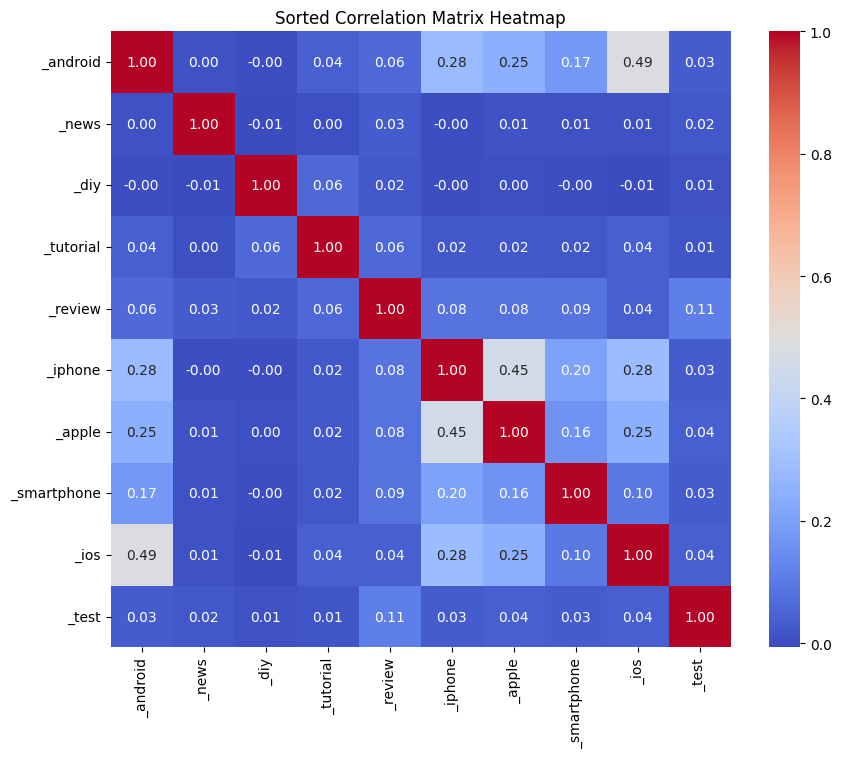

In [34]:

plt.figure(figsize=(10, 8))
sns.heatmap(sorted_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Sorted Correlation Matrix Heatmap")
plt.show()


[Back to the top](#top)

In [35]:
df.dropna(inplace=True)


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 98582 entries, 3 to 1095225
Columns: 1183 entries, channel_id to slovakia
dtypes: datetime64[ns](1), float64(6), int32(4), int64(1161), object(11)
memory usage: 889.0+ MB


**Step 7: ML/DL models used**

Models used for testing


- RandomForestRegressor

- LinearRegression

- DecisionTreeRegressor

- GradientBoostingRegressor

- KNeighborsRegressor

- XGBRegressor

- LGBMRegressor

- CatBoostRegressor

- SVR

- Elastic

- Ridge

- Lasso

- MLPRegressor

- Keras with Tensorflow

Applying log and scaler

In [37]:
target=['total_views']

In [38]:


# Assuming df is your DataFrame with more than 100 features
# 1. Standardizing the data
df_features = df.drop(target+drop_columns,axis=1)

###real
X_train, X_test, y_train, y_test = train_test_split(df_features,#X
                                                    df[target].squeeze(),#Y
                                                    test_size=0.2,
                                                    random_state=42)
##log all columns that do not have 0 including column target
df_log=df





To avoid np.NaN on columns with 0 values

In [39]:
for column in df_log.columns.to_list():
    if (column in columns_in_of_log):
                print(column)
                #df_log[column]=np.log(df_log[column])
                df[column] = df[column].apply(lambda x: np.log(x) if x > 0 else x)


df_features_log=df_log.drop(target+drop_columns,axis=1)

X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(df_features_log,#X
                                                    df_log[target].squeeze(),#Y
                                                    test_size=0.2,
                                                    random_state=42)

subscriber_count
total_views
total_videos
mean_views_last_30_videos
median_views_last_30_videos
std_views_last_30_videos
videos_per_week
year
month
day
dayofweek


Applying MinxMaxScaler

In [40]:

#X_train_scaled,X_test_scaled=dafu.scaler_of_x_train_and_x_test(X_train_log,X_test_log)
##log
#X_train_scaled,X_test_scaled=dafu.scaler_of_x_train_and_x_test(X_train_log,X_test_log)
X_train_log.replace([np.inf, -np.inf], 0, inplace=True)
X_test_log.replace([np.inf, -np.inf], 0, inplace=True)
X_train_log_scaled,X_test_log_scaled=dafu.scaler_of_x_train_and_x_test(X_train_log,X_test_log)


Defining the ML models

In [41]:

rfr_model = RandomForestRegressor(random_state=42)
lr_model = LinearRegression()
dtr_model = DecisionTreeRegressor(random_state=42)
gbr_model = GradientBoostingRegressor(random_state=42)
knr_model=KNeighborsRegressor()
xgb_model=XGBRegressor(random_state=42)
lgb_model=LGBMRegressor(random_state=42,verbose=-100)
cbr_model=CatBoostRegressor(random_state=42,verbose=False)
elastic_model = ElasticNet()
ridge_model = Ridge()
lasso_model = Lasso()
mlp_model = MLPRegressor()
tfk_model = tf.keras.Sequential([
    tf.keras.layers.Dense(512, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.12),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.04)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.02)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(1)  # Output layer for regression
])

# Compile the model

tfk_model.compile(optimizer='adam', loss='mean_squared_error')


# Train the model

models={'RandomForestRegressor':rfr_model,
        'LinearRegression':lr_model,
        'DecisionTreeRegressor':dtr_model,
        'GradientBoostingRegressor':gbr_model,
        'KNeighborsRegressor':knr_model,
        'XGBRegressor':xgb_model,
        'LGBMRegressor':lgb_model,
        'CatBoostRegressor':cbr_model,
        'Ridge':ridge_model,
        'Lasso':lasso_model,
        'MLP':mlp_model,
        'ElasticNet' : elastic_model,
        'Keras':tfk_model
        }




c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


* Loop with all models 
* Each model is saved as an object
* Each model is plotted transformed data vs real
* Metrics of each ML model are saved for later comparison

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


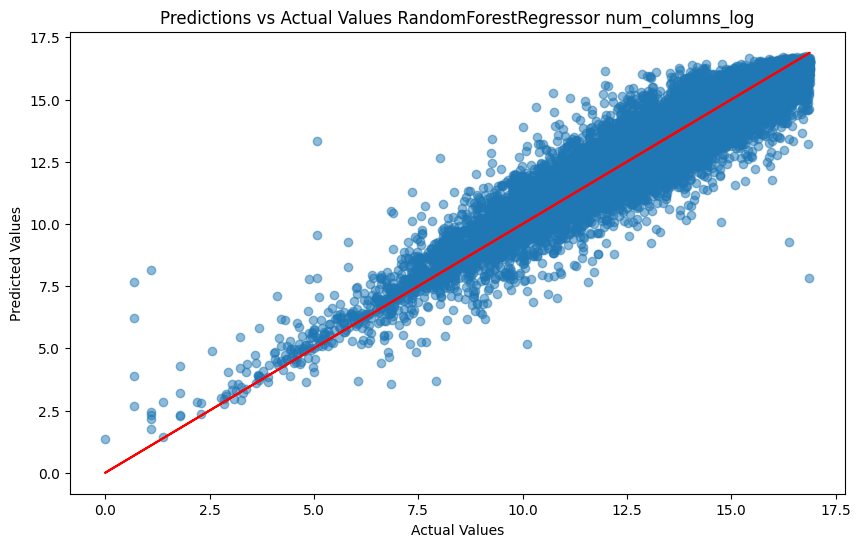

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


RandomForestRegressor R^2 score log: 0.8845
RandomForestRegressor MAE score log: 0.5804
RandomForestRegressor MSE score log: 0.6186
RandomForestRegressor RMSE score log: 0.7865
RandomForestRegressor MAPE score log: inf


RandomForestRegressor R^2 score y_test: 0.7016
RandomForestRegressor MAE score y_test: 1046928.3267
RandomForestRegressor MSE score y_test: 5330582084697.128
RandomForestRegressor RMSE score y_test: 2308805.3371
RandomForestRegressor MAPE score y_test: 108.7218


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


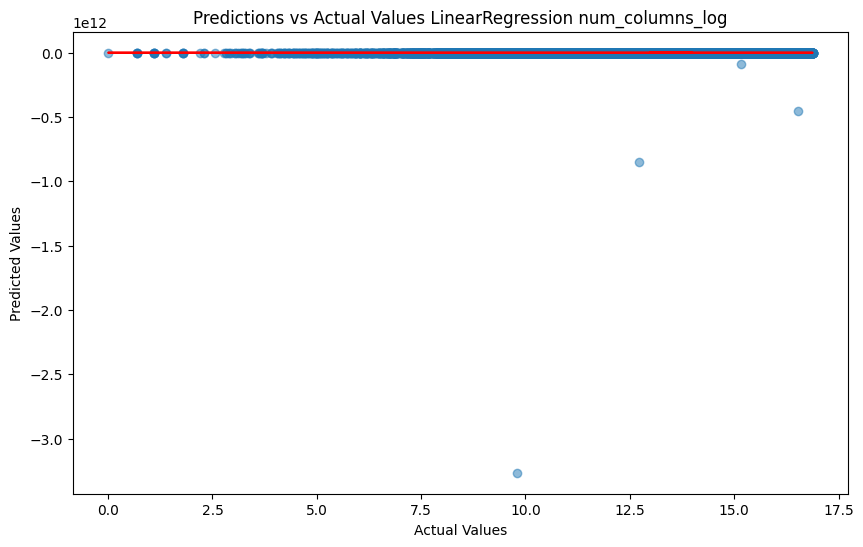

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


LinearRegression R^2 score log: -1.0988158809252936e+20
LinearRegression MAE score log: 236107692.9154
LinearRegression MSE score log: 5.8833865586496694e+20
LinearRegression RMSE score log: 24255693267.0449
LinearRegression MAPE score log: inf


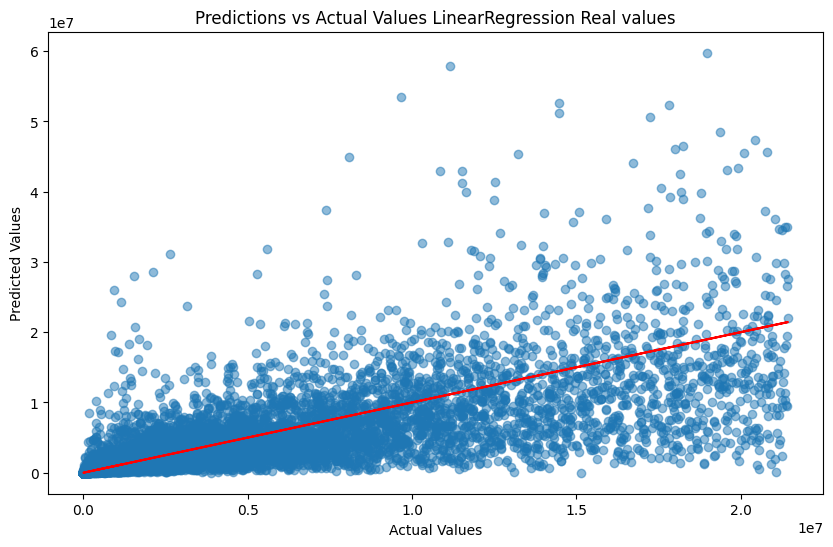

LinearRegression R^2 score y_test: 0.5145
LinearRegression MAE score y_test: 1193892.9974
LinearRegression MSE score y_test: 8672097596319.635
LinearRegression RMSE score y_test: 2944842.5419
LinearRegression MAPE score y_test: 142.6788


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


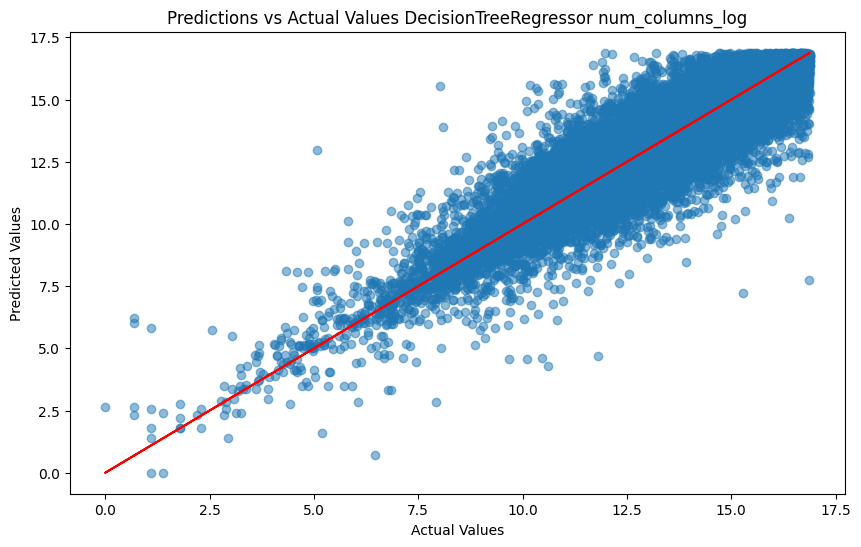

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


DecisionTreeRegressor R^2 score log: 0.7877
DecisionTreeRegressor MAE score log: 0.7931
DecisionTreeRegressor MSE score log: 1.1368
DecisionTreeRegressor RMSE score log: 1.0662
DecisionTreeRegressor MAPE score log: inf


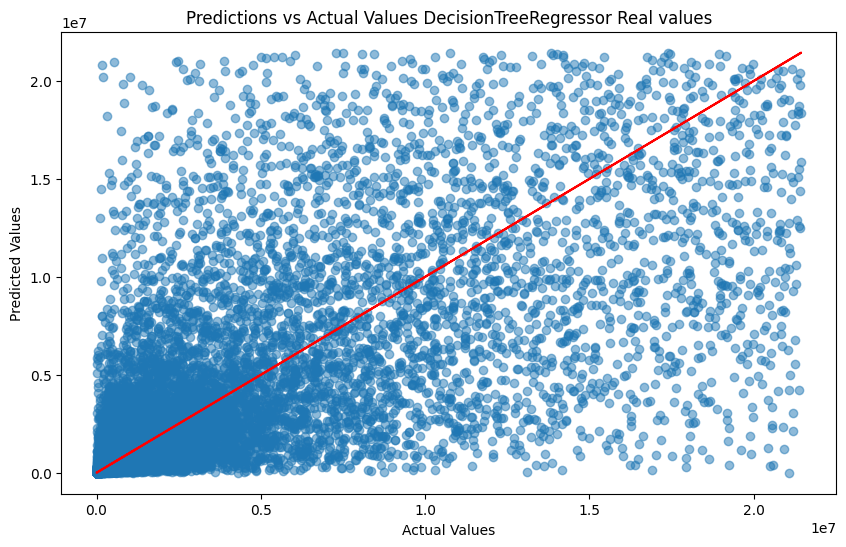

DecisionTreeRegressor R^2 score y_test: 0.4627
DecisionTreeRegressor MAE score y_test: 1461120.1013
DecisionTreeRegressor MSE score y_test: 9596642162314.336
DecisionTreeRegressor RMSE score y_test: 3097844.7608
DecisionTreeRegressor MAPE score y_test: 159.3025


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


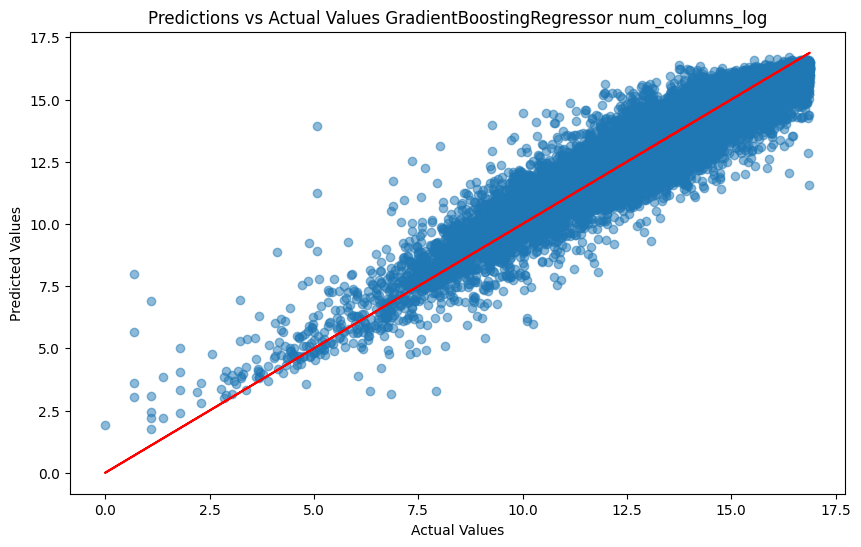

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


GradientBoostingRegressor R^2 score log: 0.8796
GradientBoostingRegressor MAE score log: 0.6035
GradientBoostingRegressor MSE score log: 0.6446
GradientBoostingRegressor RMSE score log: 0.8029
GradientBoostingRegressor MAPE score log: inf


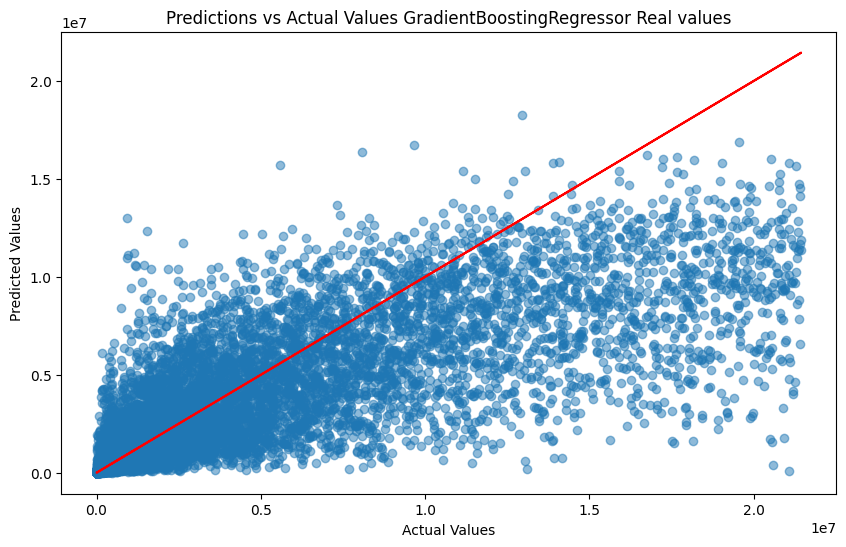

GradientBoostingRegressor R^2 score y_test: 0.6657
GradientBoostingRegressor MAE score y_test: 1097677.4194
GradientBoostingRegressor MSE score y_test: 5970528018252.738
GradientBoostingRegressor RMSE score y_test: 2443466.3939
GradientBoostingRegressor MAPE score y_test: 132.7018


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


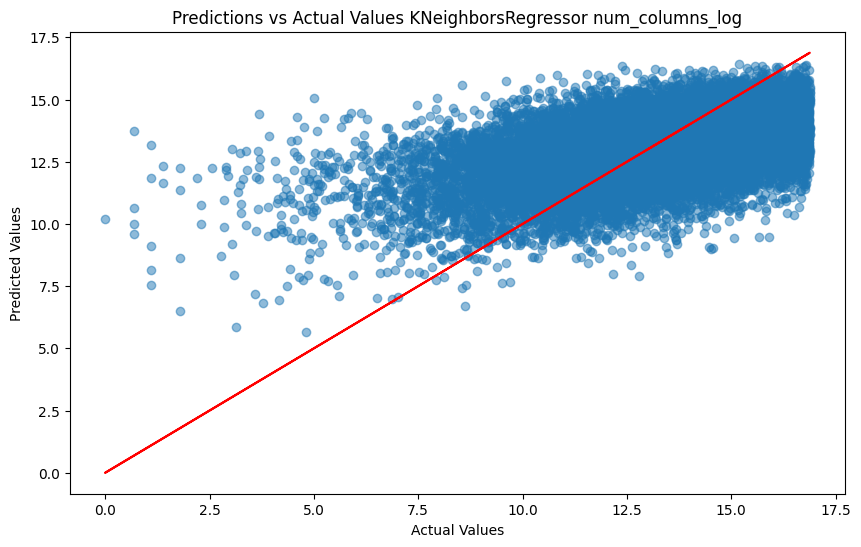

KNeighborsRegressor R^2 score log: 0.2571
KNeighborsRegressor MAE score log: 1.5478
KNeighborsRegressor MSE score log: 3.9775
KNeighborsRegressor RMSE score log: 1.9944
KNeighborsRegressor MAPE score log: inf


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


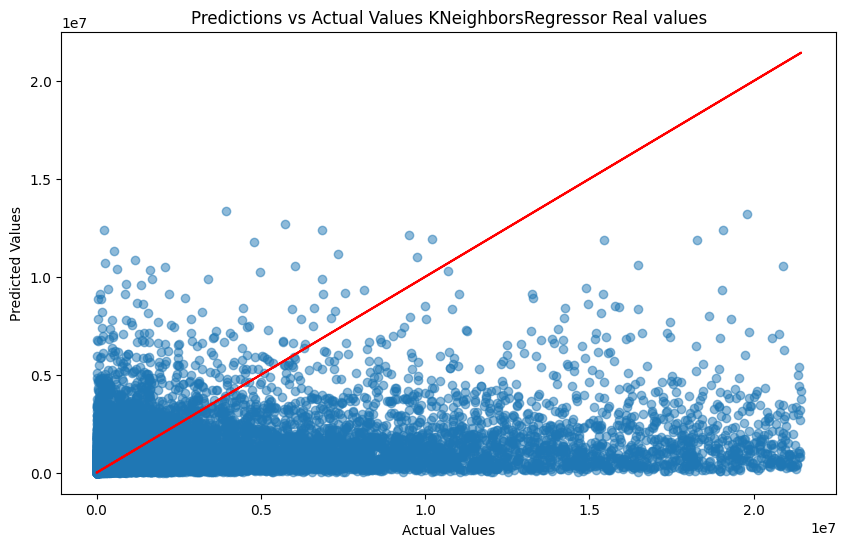

KNeighborsRegressor R^2 score y_test: -0.0269
KNeighborsRegressor MAE score y_test: 2097765.3329
KNeighborsRegressor MSE score y_test: 18342586748846.25
KNeighborsRegressor RMSE score y_test: 4282824.6227
KNeighborsRegressor MAPE score y_test: 7360.9868


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


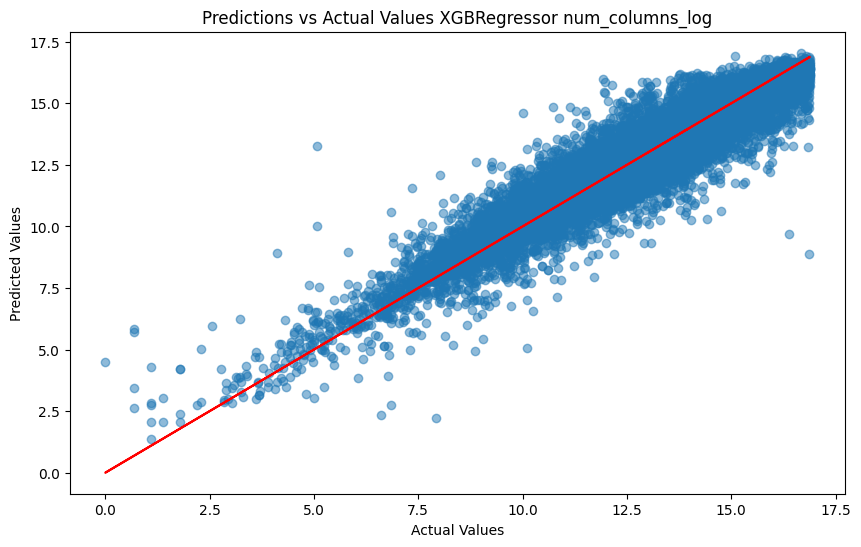

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


XGBRegressor R^2 score log: 0.8896
XGBRegressor MAE score log: 0.5675
XGBRegressor MSE score log: 0.5909
XGBRegressor RMSE score log: 0.7687
XGBRegressor MAPE score log: inf


XGBRegressor R^2 score y_test: 0.706
XGBRegressor MAE score y_test: 1022567.3846
XGBRegressor MSE score y_test: 5250668167406.627
XGBRegressor RMSE score y_test: 2291433.6489
XGBRegressor MAPE score y_test: 95.3094


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


LGBMRegressor R^2 score log: 0.8919
LGBMRegressor MAE score log: 0.5644
LGBMRegressor MSE score log: 0.579
LGBMRegressor RMSE score log: 0.7609
LGBMRegressor MAPE score log: inf


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


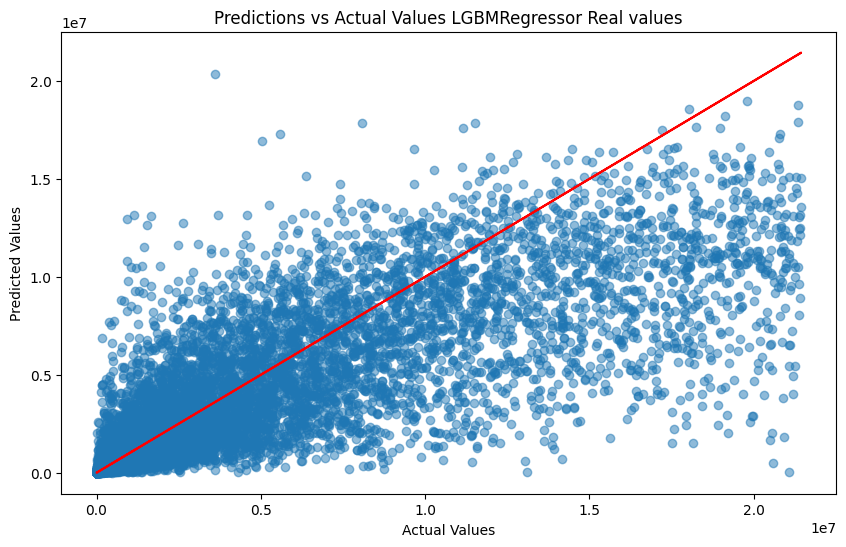

LGBMRegressor R^2 score y_test: 0.7039
LGBMRegressor MAE score y_test: 1028303.5985
LGBMRegressor MSE score y_test: 5289866281867.222
LGBMRegressor RMSE score y_test: 2299970.9307
LGBMRegressor MAPE score y_test: 105.7537


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


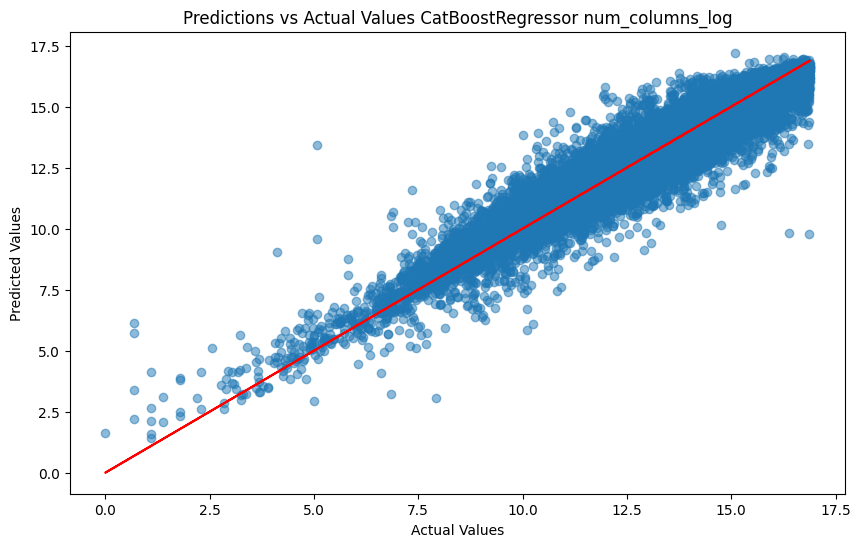

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


CatBoostRegressor R^2 score log: 0.8957
CatBoostRegressor MAE score log: 0.5531
CatBoostRegressor MSE score log: 0.5584
CatBoostRegressor RMSE score log: 0.7473
CatBoostRegressor MAPE score log: inf


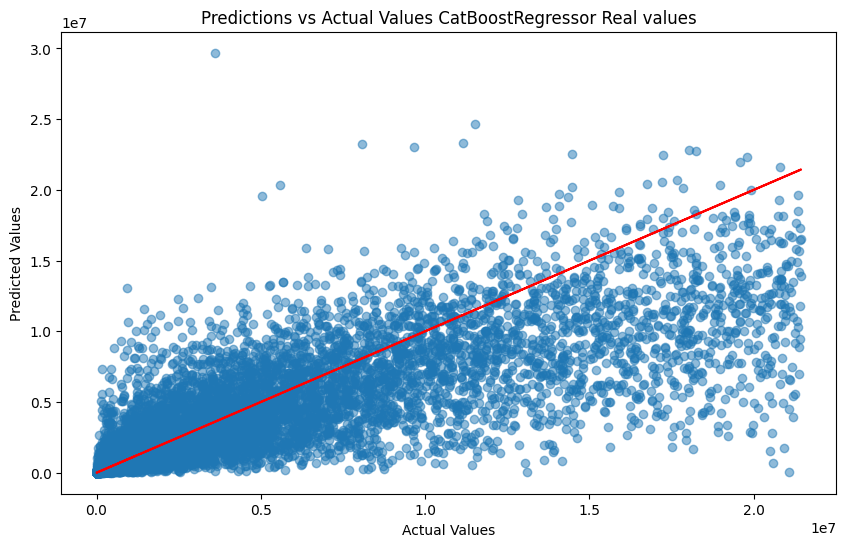

CatBoostRegressor R^2 score y_test: 0.7139
CatBoostRegressor MAE score y_test: 1003105.1847
CatBoostRegressor MSE score y_test: 5110107083992.607
CatBoostRegressor RMSE score y_test: 2260554.5966
CatBoostRegressor MAPE score y_test: 94.3261


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


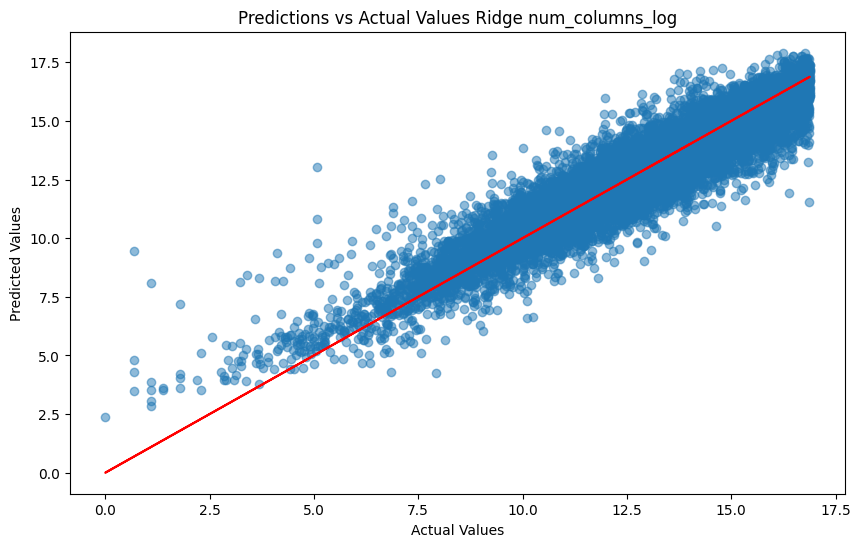

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Ridge R^2 score log: 0.8736
Ridge MAE score log: 0.6161
Ridge MSE score log: 0.677
Ridge RMSE score log: 0.8228
Ridge MAPE score log: inf


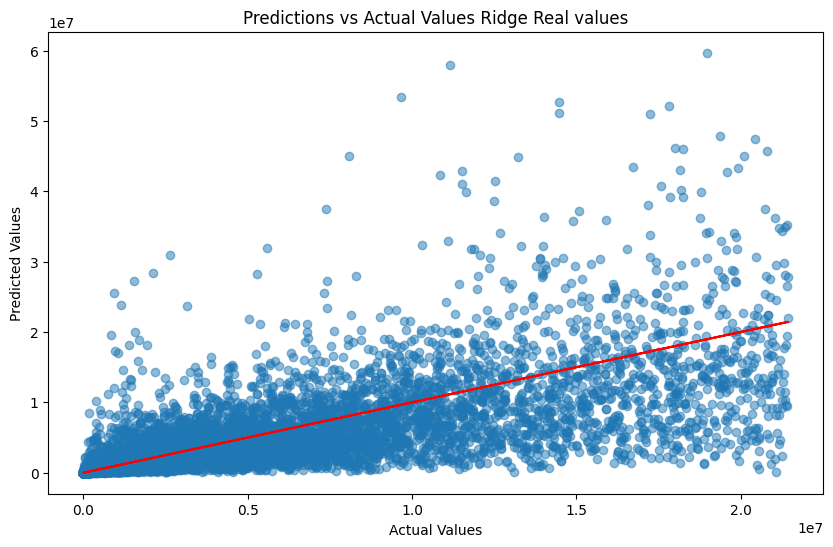

Ridge R^2 score y_test: 0.5165
Ridge MAE score y_test: 1192378.3431
Ridge MSE score y_test: 8635931059855.626
Ridge RMSE score y_test: 2938695.4691
Ridge MAPE score y_test: 142.689


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


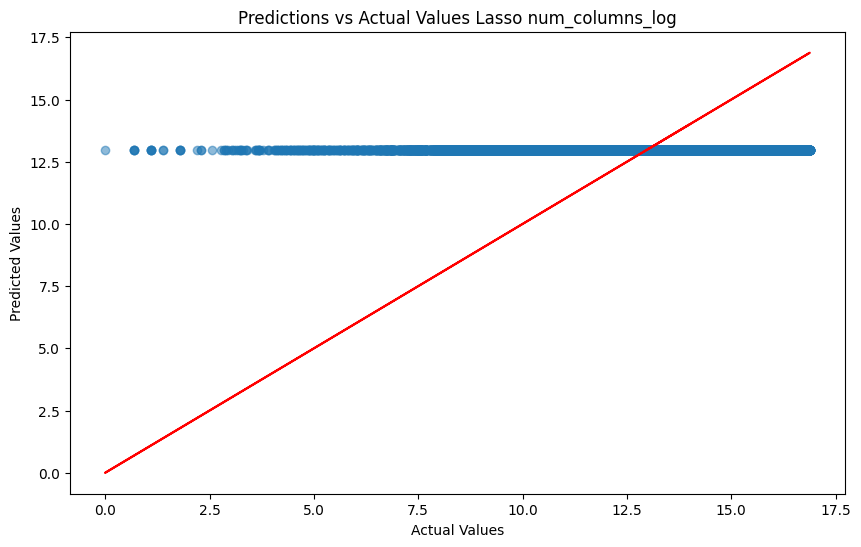

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Lasso R^2 score log: -0.0
Lasso MAE score log: 1.8154
Lasso MSE score log: 5.3544
Lasso RMSE score log: 2.314
Lasso MAPE score log: inf


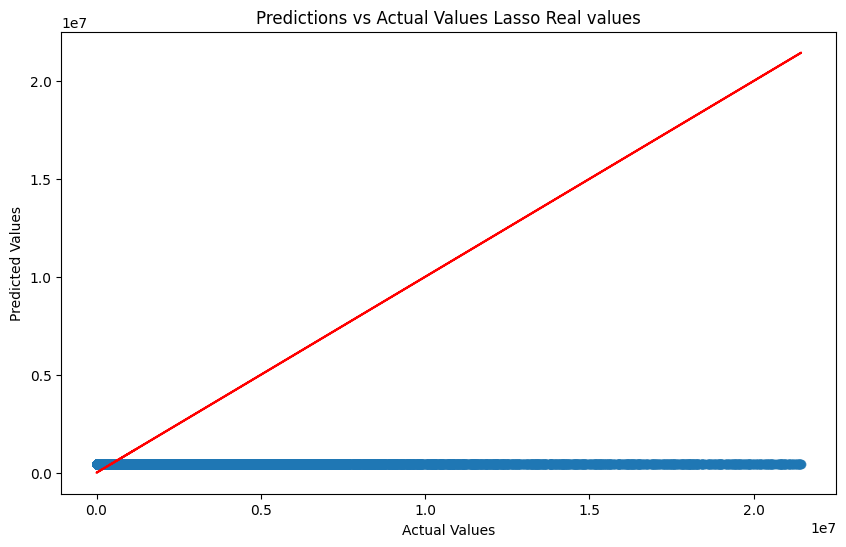

Lasso R^2 score y_test: -0.218
Lasso MAE score y_test: 2251994.0256
Lasso MSE score y_test: 21756485215182.832
Lasso RMSE score y_test: 4664384.7628
Lasso MAPE score y_test: 19341.4244


c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


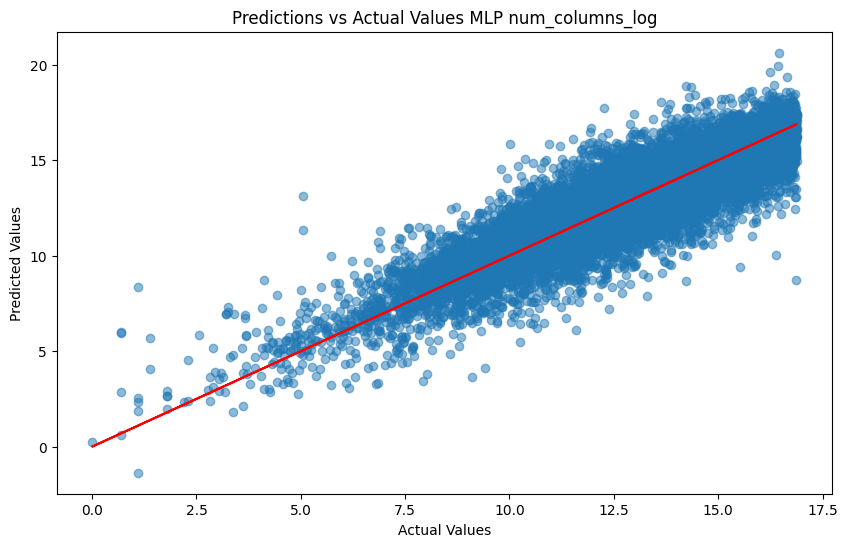

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


MLP R^2 score log: 0.7691
MLP MAE score log: 0.8368
MLP MSE score log: 1.2364
MLP RMSE score log: 1.1119
MLP MAPE score log: inf


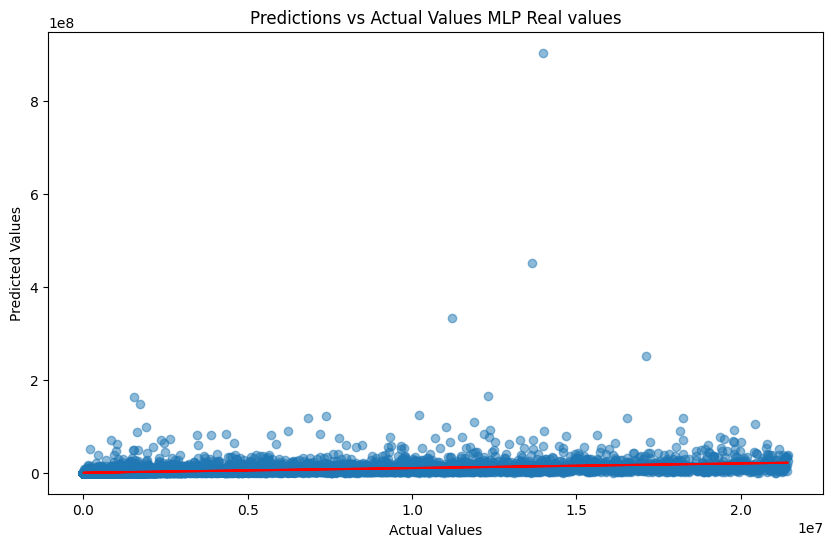

MLP R^2 score y_test: -4.1524
MLP MAE score y_test: 1971703.7816
MLP MSE score y_test: 92033682743826.33
MLP RMSE score y_test: 9593418.7203
MLP MAPE score y_test: 172.3246


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


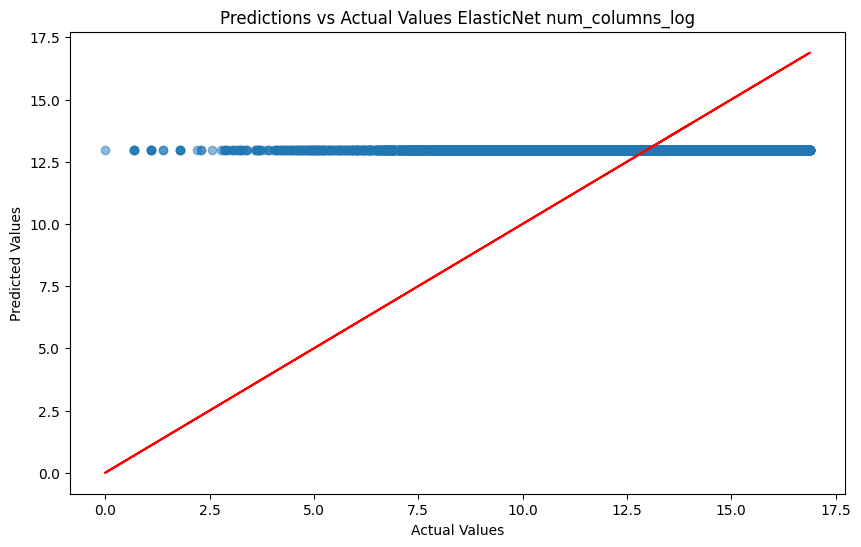

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


ElasticNet R^2 score log: -0.0
ElasticNet MAE score log: 1.8154
ElasticNet MSE score log: 5.3544
ElasticNet RMSE score log: 2.314
ElasticNet MAPE score log: inf


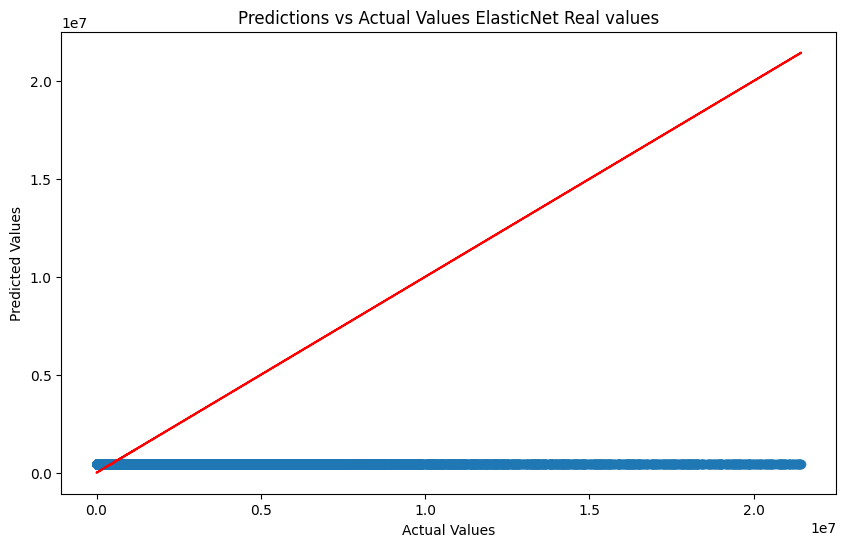

ElasticNet R^2 score y_test: -0.218
ElasticNet MAE score y_test: 2251994.0256
ElasticNet MSE score y_test: 21756485215182.832
ElasticNet RMSE score y_test: 4664384.7628
ElasticNet MAPE score y_test: 19341.4244
2465/2465 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 22.7799
617/617 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


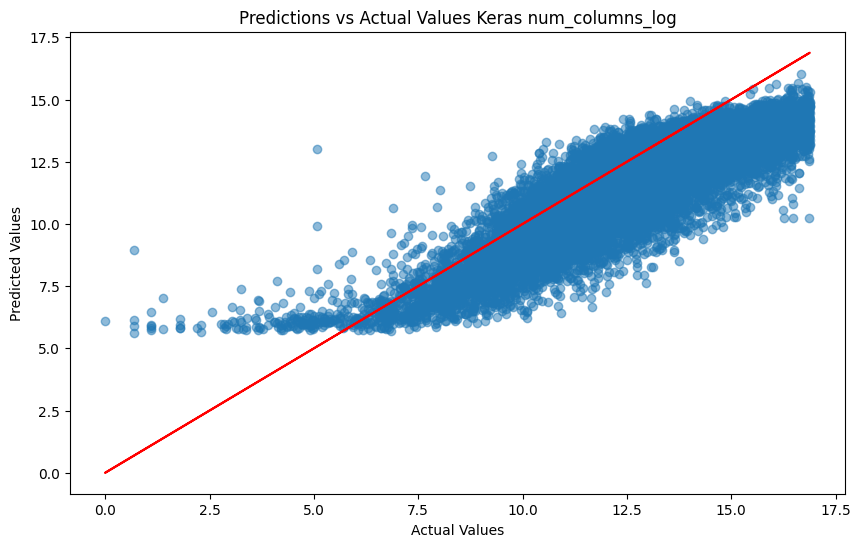

Keras R^2 score log: 0.5106
Keras MAE score log: 1.3383
Keras MSE score log: 2.6205
Keras RMSE score log: 1.6188


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


Keras MAPE score log: inf


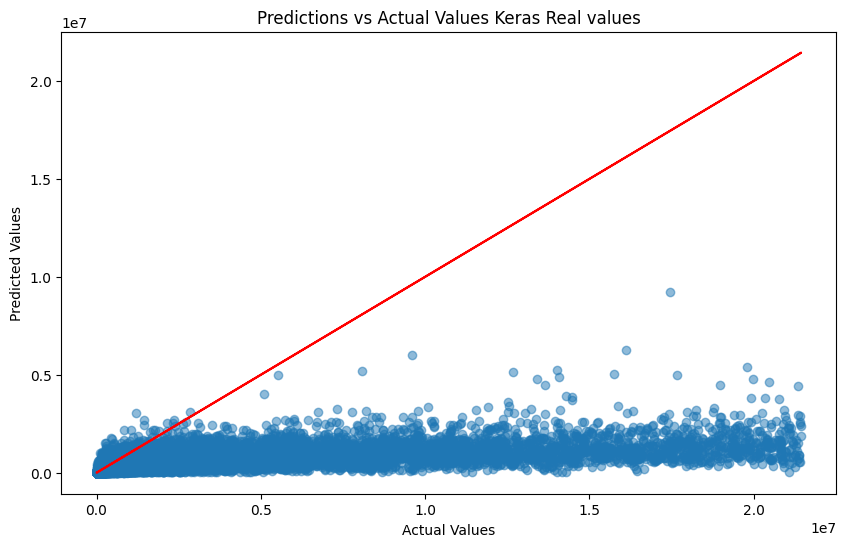

filename:./metrics/20240414_135100_Keras_num_columns_log.h5
Keras R^2 score y_test: -0.0702
Keras MAE score y_test: 2025608.9315
Keras MSE score y_test: 19116002533431.496
Keras RMSE score y_test: 4372185.0983
Keras MAPE score y_test: 18293.8066


In [42]:
list_df_metrics=[]
for key,model in models.items():
    model.fit(X_train_log_scaled, y_train_log)
    preds = model.predict(X_test_log_scaled)
    
# Metrics
    list_df_metrics.append(tb.arima_metrics(y_test_log,key+"_log","","",preds))
    exp_array = np.exp(preds)
    exp_array[np.isinf(exp_array)] = 0
    log_or_sqrt="num_columns_log"
    filename = f'./metrics/{tb.datetime_naming_convention()}_{key}_{log_or_sqrt}'
    tb.plot_test_vs_preds(y_test_log,preds,key,log_or_sqrt)
    print(f"{key} R^2 score log:", round(r2_score(y_test_log, preds), 4))
    print(f"{key} MAE score log:", round(mean_absolute_error(y_test_log, preds), 4))
    print(f"{key} MSE score log:", round(mean_squared_error(y_test_log, preds), 4))
    print(f"{key} RMSE score log:", round(np.sqrt(mean_squared_error(y_test_log, preds)), 4))
    print(f"{key} MAPE score log:", round(tb.mean_absolute_percentage_error(y_test_log, preds), 4))
            ###
            # Create a scatter plot 
            #log
            #real values
    tb.plot_test_vs_preds(y_test,exp_array,key,"Real values")
    
    if key != 'Keras':  # Keras models uses another format
        filename = f'{filename}.pkl'
        with open(filename, 'wb') as file:
            pickle.dump(model, file)
    else:
        filename = f'{filename}.h5'
        model.save(filename)  # Saves the Keras model
        print(f"filename:{filename}")

    try:
        print(f"{key} R^2 score y_test:", round(r2_score(y_test, exp_array), 4))
    except ImportError:
        print(f"{key} R^2 score y_test:", 0)
    try:      
        print(f"{key} MAE score y_test:", round(mean_absolute_error(y_test, exp_array), 4))
    except ImportError:
        print(f"{key} MAE score y_test:", 0)
    try:
        print(f"{key} MSE score y_test:", round(mean_squared_error(y_test, exp_array), 4))
    except ImportError:
        print(f"{key} MSE score y_test:", 0)
    try:
        print(f"{key} RMSE score y_test:", round(np.sqrt(mean_squared_error(y_test, exp_array)), 4))
    except ImportError:
        print(f"{key} RMSE score y_test:", 0)
    try:
        print(f"{key} MAPE score y_test:", round(tb.mean_absolute_percentage_error(y_test, exp_array), 4))
    except ImportError:
        print(f"{key} MAPE score y_test:", 0)
    list_df_metrics.append(tb.arima_metrics(y_test,key,"","",np.exp(preds)))

df_metrics=pd.concat(list_df_metrics, ignore_index=True)


[Back to the top](#top)

Saving results from metrics DataFrame

In [43]:
df_metrics.to_csv(f'./metrics/{tb.datetime_naming_convention()}_metrics.csv')

Attempt with GridSearchCV and RandomSearchCV of improving the model

With GridSearchCV

In [1]:
param_grid={
    'learning_rate':[0.1],
    'n_estimators':[1000],
    'max_depth':[3,5,8,10],
    'min_child_weight':[1],
    'gamma':[0.1,0.2],    
    'subsample':[0.8],
    'colsample_bytree':[0.5,0.9],
    'nthread':[4],
    'scale_pos_weight':[1]
}
list_df_metrics=[]
grid_search = GridSearchCV(xgb_model, param_grid, cv=3, scoring='neg_mean_squared_error', verbose=1)
# Fit GridSearchCV
grid_search.fit(X_train_log_scaled, y_train_log)  # Assuming X_train and y_train are your data

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)
preds = grid_search.predict(X_test_log_scaled)
# Metrics
print(f"{key} R^2 score:", round(r2_score(y_test_log, preds), 4))
print(f"{key} MAE score:", round(mean_absolute_error(y_test_log, preds), 4))
print(f"{key} MSE score:", round(mean_squared_error(y_test_log, preds), 4))
print(f"{key} RMSE score:", round(np.sqrt(mean_squared_error(y_test_log, preds)), 4))
print(f"{key} MAPE score:", round(tb.mean_absolute_percentage_error(y_test_log, preds), 4))
exp_array = np.exp(preds)
exp_array[np.isinf(exp_array)] = 0
log_or_sqrt="grid_search"
key="xgb_model_grid_search"
filename = f'./metrics/{tb.datetime_naming_convention()}_{key}_{log_or_sqrt}'
tb.plot_test_vs_preds(y_test_log,preds,key,log_or_sqrt)
list_df_metrics.append(tb.arima_metrics(y_test_log,'grid_search_xgb',"","",preds))
tb.plot_test_vs_preds(y_test,exp_array,key,"Real values")

try:
        print(f"{key} R^2 score y_test:", round(r2_score(y_test, exp_array), 4))
except (ZeroDivisionError,ValueError,OverflowError):
        print(f"{key} R^2 score y_test:", 0)
try:      
        print(f"{key} MAE score y_test:", round(mean_absolute_error(y_test, exp_array), 4))
except (ZeroDivisionError,ValueError,OverflowError):
        print(f"{key} MAE score y_test:", 0)
try:
        print(f"{key} MSE score y_test:", round(mean_squared_error(y_test, exp_array), 4))
except (ZeroDivisionError,ValueError,OverflowError):
        print(f"{key} MSE score y_test:", 0)
try:
        print(f"{key} RMSE score y_test:", round(np.sqrt(mean_squared_error(y_test, exp_array)), 4))
except (ZeroDivisionError,ValueError,OverflowError):
        print(f"{key} RMSE score y_test:", 0)
try:
        print(f"{key} MAPE score y_test:", round(tb.mean_absolute_percentage_error(y_test, exp_array), 4))
except (ZeroDivisionError,ValueError,OverflowError):
        print(f"{key} MAPE score y_test:", 0)
list_df_metrics.append(tb.arima_metrics(y_test,key,"","",np.exp(preds)))
df_metrics=pd.concat(list_df_metrics, ignore_index=True)

NameError: name 'GridSearchCV' is not defined

With RandomSearchCV

[Back to the top](#top)

c:\Users\Jorge\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:307: UserWarning: The total space of parameters 16 is smaller than n_iter=50. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 16 candidates, totalling 48 fits
Best parameters: {'subsample': 0.8, 'scale_pos_weight': 1, 'nthread': 4, 'n_estimators': 1000, 'min_child_weight': 1, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.1, 'colsample_bytree': 0.5}
Best score: -0.5592201978862404
Keras R^2 score: 0.8947
Keras MAE score: 0.5547
Keras MSE score: 0.5639
Keras RMSE score: 0.751
Keras MAPE score: inf


c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


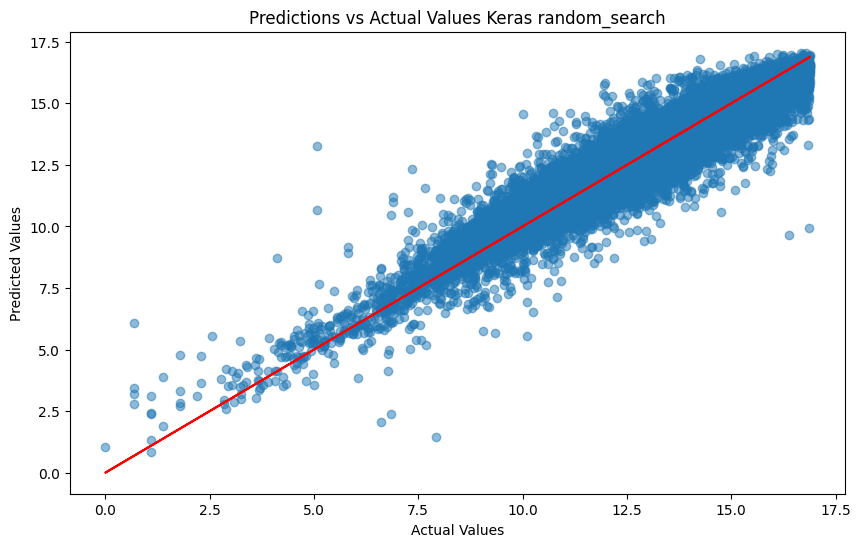

c:\Users\Jorge\Documentos\GitHub\copia_local_github_proyecto_ml\project\results_notebook\scripts\toolbox_ML.py:890: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


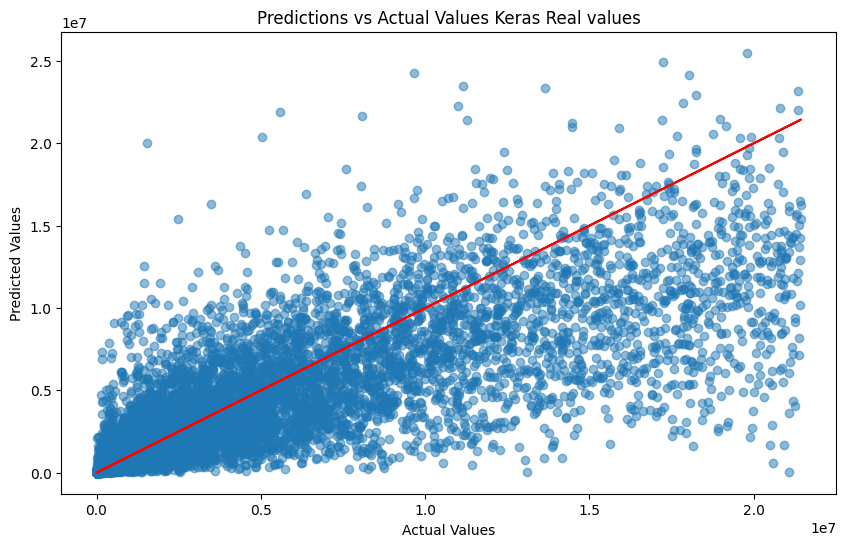

filename:./metrics/20240414_155506_Keras_random_search.h5
Keras R^2 score y_test: 0.7105
Keras MAE score y_test: 1006335.8571
Keras MSE score y_test: 5170487041709.505
Keras RMSE score y_test: 2273870.498
Keras MAPE score y_test: 93.5441


In [ ]:
param_grid={
    'learning_rate':[0.1],
    'n_estimators':[1000],
    'max_depth':[3,5,8,10],
    'min_child_weight':[1],
    'gamma':[0.1,0.2],    
    'subsample':[0.8],
    'colsample_bytree':[0.5,0.9],
    'nthread':[4],
    'scale_pos_weight':[1]
}
random_search = RandomizedSearchCV(xgb_model, param_grid, n_iter=50, scoring='neg_mean_squared_error', cv=3, verbose=1, random_state=42)
key="xgb_model_random_search"

# Fit GridSearchCV
random_search.fit(X_train_log_scaled, y_train_log)  # Assuming X_train and y_train are your data

# Best parameters and best score
print("Best parameters:", random_search.best_params_)
print("Best score:", random_search.best_score_)
preds = random_search.predict(X_test_log_scaled)
# Metrics
print(f"{key} R^2 score:", round(r2_score(y_test_log, preds), 4))
print(f"{key} MAE score:", round(mean_absolute_error(y_test_log, preds), 4))
print(f"{key} MSE score:", round(mean_squared_error(y_test_log, preds), 4))
print(f"{key} RMSE score:", round(np.sqrt(mean_squared_error(y_test_log, preds)), 4))
print(f"{key} MAPE score:", round(tb.mean_absolute_percentage_error(y_test_log, preds), 4))
list_df_metrics.append(tb.arima_metrics(y_test_log,'random_search_xgb',"","",preds))
###
exp_array = np.exp(preds)
exp_array[np.isinf(exp_array)] = 0
log_or_sqrt="random_search"
filename = f'./metrics/{tb.datetime_naming_convention()}_{key}_{log_or_sqrt}'
tb.plot_test_vs_preds(y_test_log,preds,key,log_or_sqrt)
list_df_metrics.append(tb.arima_metrics(y_test_log,'random_search_xgb',"","",preds))
tb.plot_test_vs_preds(y_test,exp_array,key,"Real values")

try:
        print(f"{key} R^2 score y_test:", round(r2_score(y_test, exp_array), 4))
except (ZeroDivisionError,ValueError,OverflowError):
        print(f"{key} R^2 score y_test:", 0)

try:      
        print(f"{key} MAE score y_test:", round(mean_absolute_error(y_test, exp_array), 4))
except (ZeroDivisionError,ValueError,OverflowError):
        print(f"{key} MAE score y_test:", 0)
try:
        print(f"{key} MSE score y_test:", round(mean_squared_error(y_test, exp_array), 4))
except (ZeroDivisionError,ValueError,OverflowError):
        print(f"{key} MSE score y_test:", 0)
try:
        print(f"{key} RMSE score y_test:", round(np.sqrt(mean_squared_error(y_test, exp_array)), 4))
except (ZeroDivisionError,ValueError,OverflowError):
        print(f"{key} RMSE score y_test:", 0)
try:
        print(f"{key} MAPE score y_test:", round(tb.mean_absolute_percentage_error(y_test, exp_array), 4))
except (ZeroDivisionError,ValueError,OverflowError):
        print(f"{key} MAPE score y_test:", 0)
list_df_metrics.append(tb.arima_metrics(y_test,key,"","",np.exp(preds)))

df_metrics=pd.concat(list_df_metrics, ignore_index=True)
###
df_metrics=pd.concat(list_df_metrics, ignore_index=True)

[Back to the top](#top)

In [50]:
df_metrics.to_csv(f'./models/{tb.datetime_naming_convention()}_randomsearch_gridsearch_metrics.csv')

Building metrics DataFrame for RandomSearch and GridSearch 

In [51]:
df_metrics=pd.concat(list_df_metrics, ignore_index=True)


In [52]:
df_metrics

model  r_square_score  mae_score  mse_score  rmse_score  \
0  {grid_search_xgb}          0.8947     0.5547     0.5639       0.751   

   mape_score  
0         inf

Saving DataFrame

In [66]:
df_metrics.to_csv(f'./models/{tb.datetime_naming_convention()}_randomsearch_gridsearch_metrics.csv')

Saving both models

In [67]:
partial_filename= f'./models/{tb.datetime_naming_convention()}'
# Save the GridSearchCV or RandomizedSearchCV object
with open(f'{partial_filename}_grid_search_xgb.pkl', 'wb') as file:
    pickle.dump(grid_search, file)  # Change 'grid_search' to 'random_search' if needed
with open(f'{partial_filename}_random_search_xgb.pkl', 'wb') as file:
    pickle.dump(grid_search, file)  # Change 'grid_search' to 'random_search' if needed

Applying log and sqrt to target as results are not satisfactory

Excerpt from 

https://www.kaggle.com/discussions/product-feedback/164183

**There are four assumptions associated with a linear regression model:**

*1-Linearity*: The relationship between X and the mean of Y is linear.

*2-Homoscedasticity*: The variance of residual is the same for any value of X.

*3-Independence*: Observations are independent of each other.

*4-Normality*: For any fixed value of X, Y is normally distributed

*Skewness* is a measure of the symmetry in a distribution. A symmetrical data set will have a skewness equal to 0. So, a normal distribution will have a skewness of 0. Skewness essentially measures the relative size of the two tails.

so that been said ,the objective of choosing features with *skewed_feats>0.75* is because we are searching to work with features that have a more normal-like distribution so this why we apply a log transformation so to normalize the distribution ( skewness =0) cause models cause linear models work better on or normalized data. well to be more specific it's a good practice to always normalize your features.

**Transformations**

In data analysis transformation is the replacement of a variable by a function of that variable. Example replacing a variable x by the square root of x or the logarithm of x.

**Reasons for using transformations**

*Convenience*: A transformed scale may be as natural as the original scale and more convenient for a specific purpose (e.g. percentages rather than original data, sines rather than degrees). One important example is standardization.

*Reducing skewness*: A transformation may be used to reduce skewness. A distribution that is symmetric or nearly so is often easier to handle and interpret than a skewed distribution. To reduce right skewness, take roots or logarithms or reciprocals (roots are weakest). This is the commonest problem in practice. To reduce left skewness, take squares or cubes or higher powers.

*Equal spreads*: A transformation may be used to produce approximately equal spreads, despite marked variations in level, which again makes data easier to handle and interpret.

*Linear relationships*: When looking at relationships between variables, it is often far easier to think about patterns that are approximately linear than about patterns that are highly curved.

*Additive relationships*: Relationships are often easier to analyse when additive rather than multiplicative.

**Logarithm**

The logarithm, x to log base 10 of x, or x to log base e of x (ln x), or x to log base 2 of x, is a strong transformation with a major effect on distribution shape. It is commonly used for reducing right skewness and is often appropriate for measured variables. It can not be applied to zero or negative values. One unit on a logarithmic scale means a multiplication by the base of logarithms being used.

**Step 8: How to get keywords DataFrame**

In [82]:
keywords_list=[]
keywords_dict={}
for index,row in df.iterrows():
    keywords=row['keywords'].split(",")
    for keyword in keywords:
        if dafu.is_english(keyword):
            keyword= keyword.lower()
            keyword= keyword.replace(' ', '_')
            if keyword not in keywords_list:
                keywords_list.append(keyword)
                keywords_dict[keyword]=1
            else:
                keywords_dict[keyword]=keywords_dict[keyword]+1

# Convert the dictionary to a DataFrame
keywords_df = pd.DataFrame.from_dict(keywords_dict, orient='index', columns=['Count'])

# Reset the index to make the keywords a column
keywords_df.reset_index(inplace=True)
keywords_df.rename(columns={'index': 'Keyword'}, inplace=True)
#Uncomment this line to save DataFrame
#keywords_df.to_csv('./data/youtube_chanels_1M_clean_keywords.csv',index=False)

KeyboardInterrupt: 

**THANKS**

[Back to the top](#top)